In [1]:
!pip install orbit-ml

     |████████████████████████████████| 465 kB 3.2 MB/s 
     |████████████████████████████████| 11.2 MB 47.0 MB/s 
     |████████████████████████████████| 713 kB 33.5 MB/s 
     |████████████████████████████████| 9.8 MB 37.9 MB/s 
     |████████████████████████████████| 895 kB 52.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 3.2 MB/s 


In [4]:
!pip install shap

In [5]:
!pip install tslearn

     |████████████████████████████████| 793 kB 4.1 MB/s 


In [6]:
from fbprophet import Prophet
from pmdarima import auto_arima
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pylab import rcParams
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, accuracy_score,r2_score
import xgboost as xgb
import datetime
import dateutil
from fbprophet.plot import add_changepoints_to_plot

from orbit.utils.dataset import load_iclaims
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data
import shap

from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.ensemble import GradientBoostingRegressor

from IPython.display import display
from tqdm.autonotebook import tqdm
rcParams['figure.figsize'] = 20, 10
%matplotlib inline

#Import data

In [7]:


df = pd.read_excel('/content/Sales_and_Promotions.xlsx')
#df = df.rename(columns={'DATE':'ds', 'Brand1':'y'})
#df = df[['ds', 'y']]

#EDA

In [ ]:
#es werden Korrelationen paarweise gebildet, um erste Einblicke in die Daten zu verschaffen

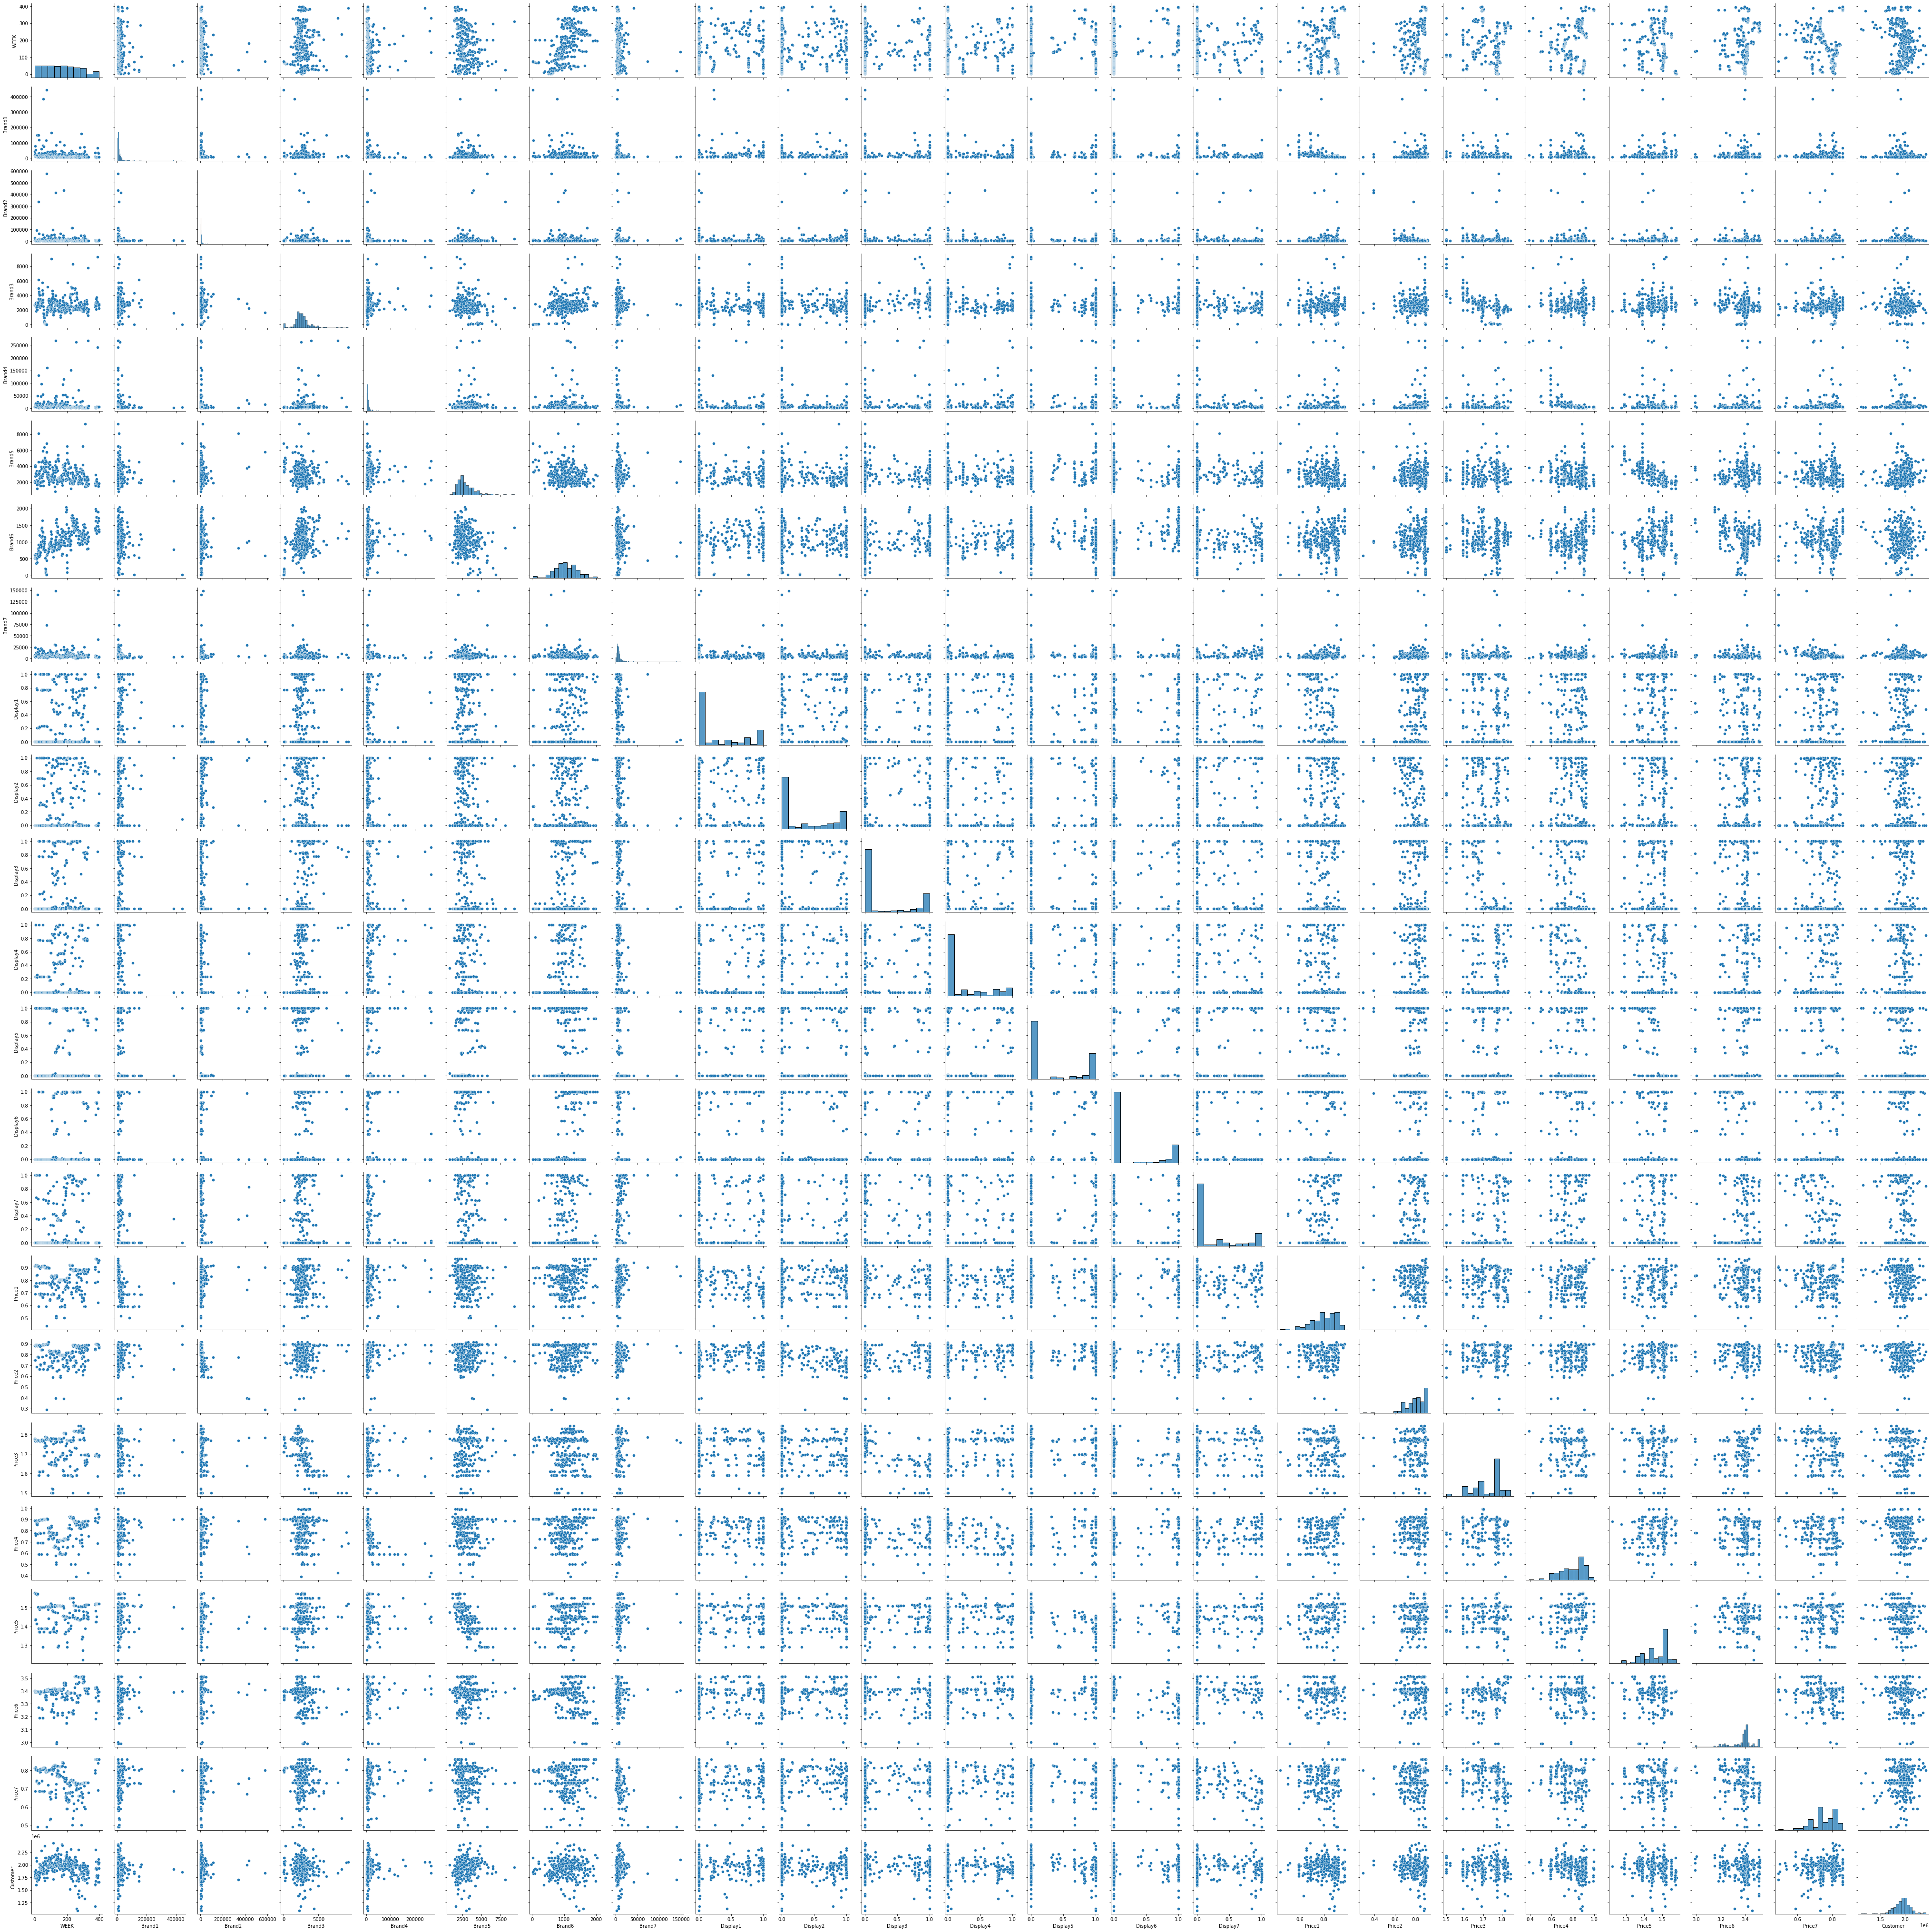

In [ ]:
sns.pairplot(df)

In [ ]:
#Verteilungen von einzelnen Spalten

Text(0.5, 0.98, 'Histplot of Brands')

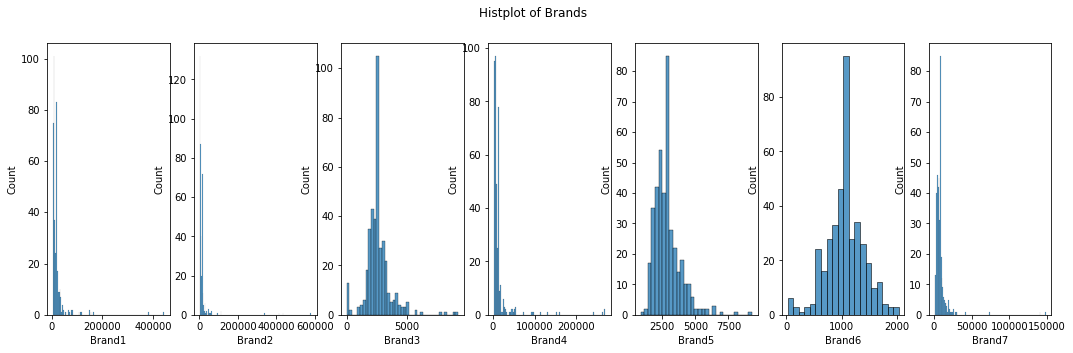

In [ ]:
fig, ax = plt.subplots(1,7, figsize=(18,5))
j=0
for i in ['Brand1', 'Brand2', 'Brand3',
              'Brand4', 'Brand5', 'Brand6', 'Brand7']:
    sns.histplot(df[i], ax=ax[j])
    j+=1
fig.suptitle('Histplot of Brands')

Text(0.5, 0.98, 'Histplot of Prices')

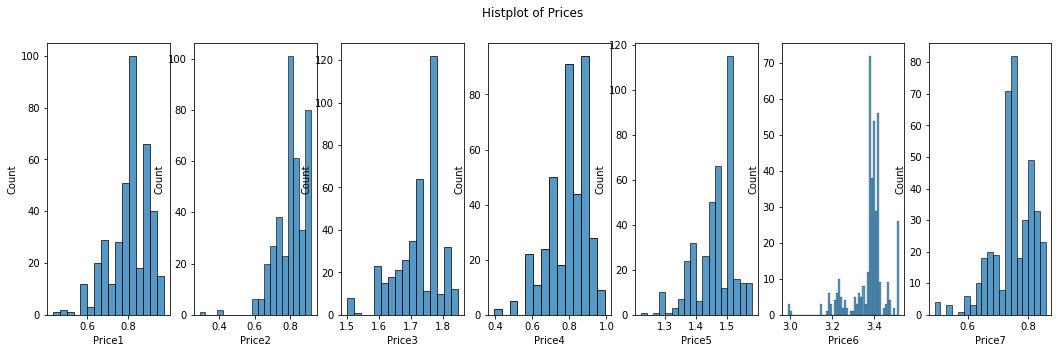

In [ ]:
fig, ax = plt.subplots(1,7, figsize=(18,5))
j=0
for i in ['Price1', 'Price2', 'Price3', 'Price4', 'Price5', 'Price6', 'Price7']:
    sns.histplot(df[i], ax=ax[j])
    j+=1
fig.suptitle('Histplot of Prices')

Text(0.5, 0.98, 'Histplot of Displays')

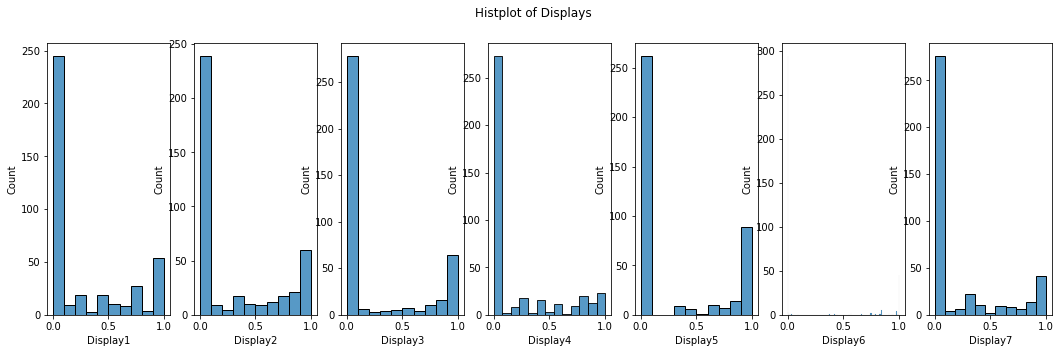

In [ ]:
fig, ax = plt.subplots(1,7, figsize=(18,5))
j=0
for i in ['Display1', 'Display2', 'Display3',
              'Display4', 'Display5', 'Display6', 'Display7']:
    sns.histplot(df[i], ax=ax[j])
    j+=1
fig.suptitle('Histplot of Displays')

<AxesSubplot:xlabel='Customer', ylabel='Count'>

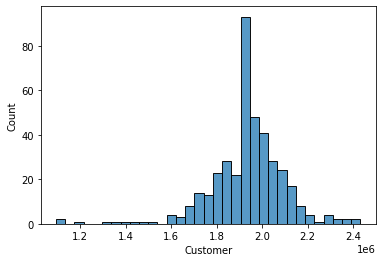

In [ ]:
sns.histplot(df['Customer'])

#Preprocessing

In [ ]:
df['random'] = np.random.randint(1, 1000, df.shape[0])


# eine fiktive Datumsspalte wird erstellt
new_date=[]
campaign_start_enddate_string = "2014-01-01"
event_date_end = datetime.datetime.strptime(campaign_start_enddate_string, "%Y-%m-%d").date()
#event_date_end =campaign_start_enddate_string
weeks = list(range(0,1))+df['WEEK'].unique().tolist()
weeks = weeks[0:len(weeks)-1]

for i in weeks:
    #i = -i
    
    i = float(i)
    sc_end_date_minus_11 = pd.to_datetime((event_date_end - dateutil.relativedelta.relativedelta(weeks=-i))).date().strftime("%Y-%m-%d")
    new_date.append(sc_end_date_minus_11)
    



df['DATE'] = new_date
df['DATE'] = df['DATE'].astype('datetime64')

df.index = df.DATE
df = df.resample(rule='W-WED').mean()
df['WEEK'] = range(1, len(df)+1)


df.reset_index(inplace=True)

df['DATE_WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week  
df['DATE_year'] = df['DATE'].dt.year  
df['DATE_month'] = df['DATE'].dt.month 
df['DATE_week_year'] = df['DATE'].dt.year.astype(int).astype(str)+ '_'+ df['DATE'].dt.isocalendar().week.astype(int).astype(str)
df['DATE_month_year'] = df['DATE'].dt.year.astype(int).astype(str)+ '_'+ df['DATE'].dt.month.astype(int).astype(str)
df[['Display1', 'Display2', 'Display3', 'Display4', 'Display5', 'Display6', 'Display7']] = df[['Display1', 'Display2', 'Display3', 'Display4', 'Display5', 'Display6', 'Display7']].fillna(0)
df = df.fillna( df.mean() ) 

df.index = df.DATE
df = df.drop('DATE', axis=1)

df.index.freq = 'W-WED'

#check_point
df.to_excel('data_prep.xlsx')

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


#TS-Clustering

In [ ]:
pivot_t = df[['Brand1', 'Brand2', 'Brand3', 'Brand4', 'Brand5', 'Brand6', 'Brand7']]
#pivot_t.reset_index(inplace=True)
#pivot_t.index= pivot_t.DATE_WEEK_NUMBER
#pivot_t = pivot_t.drop([ 'DATE_WEEK_NUMBER', 'DATE'], axis=1)
pivot_t

Brand1        Brand2  ...       Brand6        Brand7
DATE                                    ...                           
2014-01-01  20347.000000   7152.000000  ...   617.000000   7940.000000
2014-01-08  44351.000000  30335.000000  ...   515.000000   4336.000000
2014-01-15  25177.000000   9114.000000  ...   565.000000   5619.000000
2014-01-22  11032.000000  10973.000000  ...   591.000000  24322.000000
2014-01-29  77269.000000   4649.000000  ...   550.000000   4031.000000
...                  ...           ...  ...          ...           ...
2021-07-14  20810.384615  16104.026627  ...  1056.881657   8518.236686
2021-07-21   7086.000000   5239.000000  ...  1632.000000   3918.000000
2021-07-28   7297.000000   6825.000000  ...  1373.000000   4245.000000
2021-08-04   6720.000000  11413.000000  ...  1306.000000   3520.000000
2021-08-11   6734.000000   9878.000000  ...  1311.000000   3717.000000

[398 rows x 7 columns]

<AxesSubplot:xlabel='DATE_WEEK_NUMBER'>

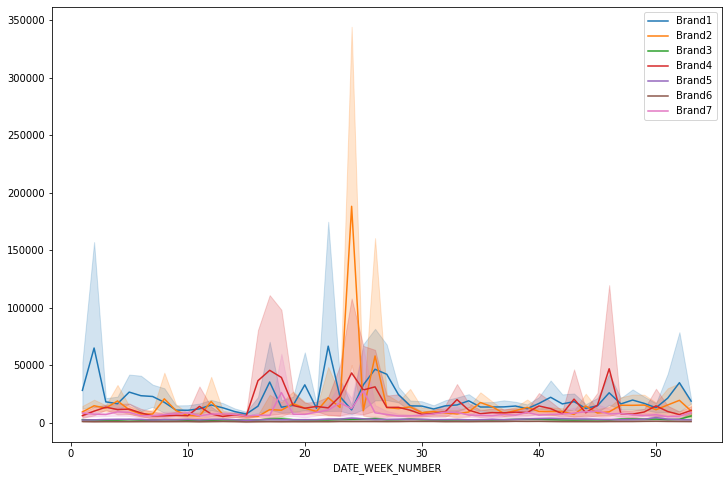

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data = pivot_t, dashes=False)

In [ ]:
#Transformation mit StandardScaler
#TimeSeriesKMeans
#Elbow-Method
#Silhouette Score

  0%|          | 0/6 [00:00<?, ?it/s]

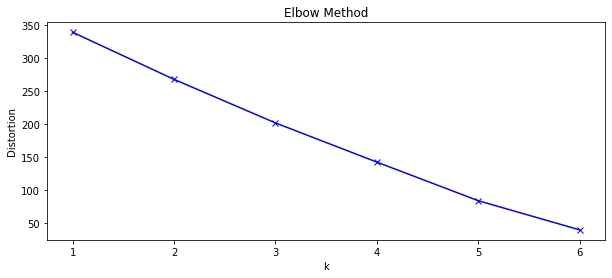

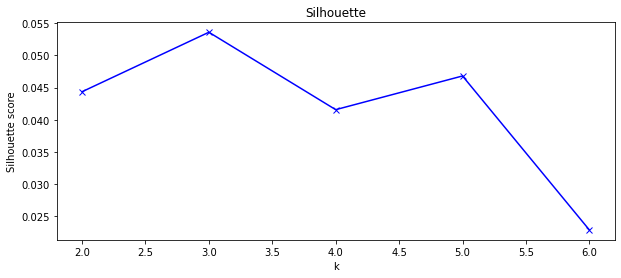

In [ ]:
scaler = StandardScaler()
ts_scaled = scaler.fit_transform(pivot_t).T
#ts_scaled.shape
#ts_scaled
#plt.figure(figsize=(12,8))
#plt.plot(ts_scaled.T)

distortions = []
silhouette = []
K = range(1, 7)
#Elbow: es werden die durchschnittlichen Distanzen von jedem Punk zum Centroid des Clusters berechnet 

for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=50)
    kmeanModel.fit(ts_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(ts_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

2-Dimensional data passed. Assuming these are 7 1-dimensional timeseries
2-Dimensional data passed. Assuming these are 7 1-dimensional timeseries


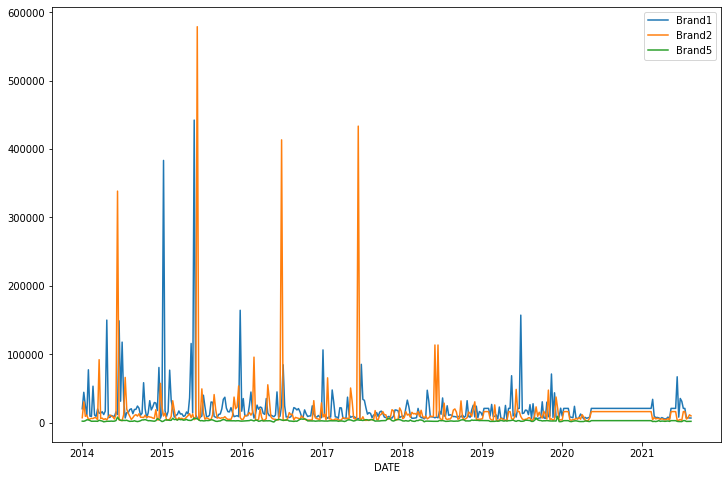

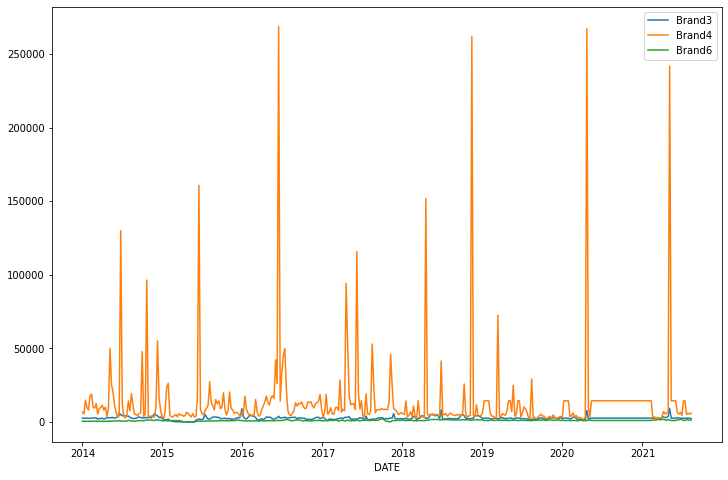

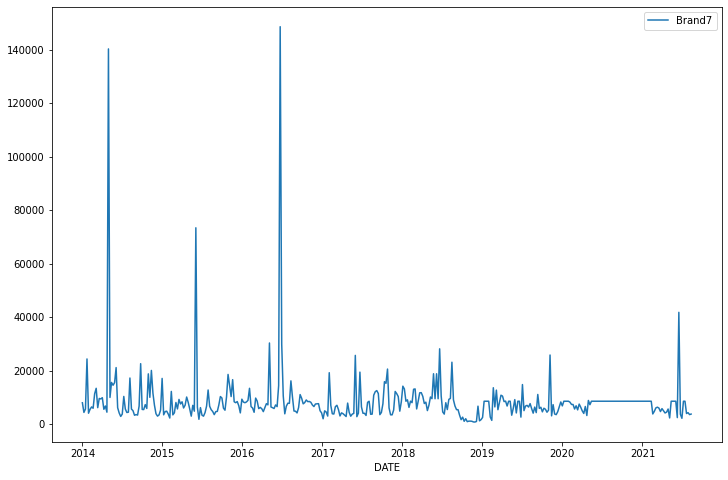

In [ ]:
n_clusters = 3
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=3, max_iter=10)
ts_kmeans.fit(ts_scaled)
ts_kmeans.predict(ts_scaled)

z = dict()
for cluster, sku in zip(ts_kmeans.predict(ts_scaled),pivot_t.columns):
    if z.get(str(cluster)) is None:
        z[str(cluster)] = [sku]
    else:
        z[str(cluster)] = z[str(cluster)] + [sku]

for cluster in z.keys():
    
    plt.figure(figsize=(12,8))
    sns.lineplot(data = pivot_t[z[cluster]], dashes=False)

Text(0.5, 0.98, 'Histplot of Brands')

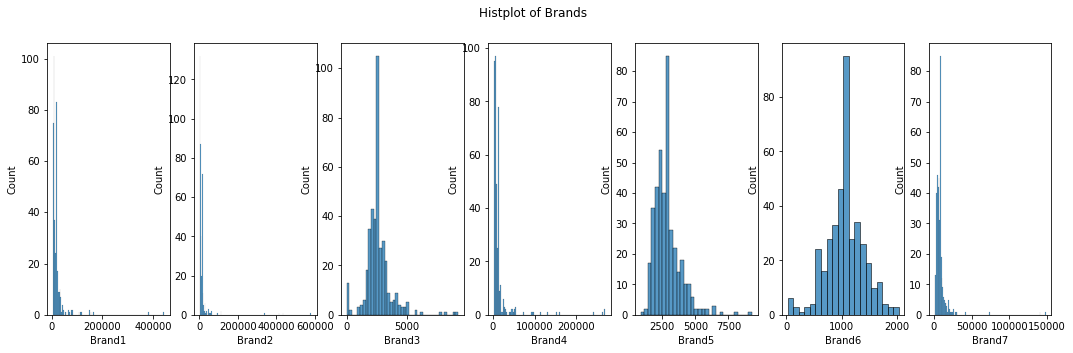

In [ ]:
fig, ax = plt.subplots(1,7, figsize=(18,5))
j=0
for i in ['Brand1', 'Brand2', 'Brand3',
              'Brand4', 'Brand5', 'Brand6', 'Brand7']:
    sns.histplot(df[i], ax=ax[j])
    j+=1
fig.suptitle('Histplot of Brands')

In [ ]:
# (1) Calculate the effect of different prices and promotions on sales per brand

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 398 entries, 2014-01-01 to 2021-08-11
Freq: W-WED
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WEEK              398 non-null    int64  
 1   Brand1            398 non-null    float64
 2   Brand2            398 non-null    float64
 3   Brand3            398 non-null    float64
 4   Brand4            398 non-null    float64
 5   Brand5            398 non-null    float64
 6   Brand6            398 non-null    float64
 7   Brand7            398 non-null    float64
 8   Display1          398 non-null    float64
 9   Display2          398 non-null    float64
 10  Display3          398 non-null    float64
 11  Display4          398 non-null    float64
 12  Display5          398 non-null    float64
 13  Display6          398 non-null    float64
 14  Display7          398 non-null    float64
 15  Price1            398 non-null    float64
 16  Price2       

In [ ]:
def calc_effect(df, column_name = 'Brand1'):

  train = df[:199]
  test = df[199:]

  X_train = train.drop([column_name], axis=1)
  X_test = test.drop([column_name], axis=1)

  y_train = train[column_name]
  y_test = test[column_name]

  regr = xgb.XGBRegressor(objective ='reg:squarederror')
  regr.fit(X_train, y_train)

  y_pred = regr.predict(X_test)




  feature_important = regr.get_booster().get_score(importance_type='gain')
  keys = list(feature_important.keys())
  values = list(feature_important.values())

  xgb_data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
  plot = xgb_data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))#
  plt.show()
  print('sq_mean_squared_error', mean_squared_error(y_test, y_pred, squared=True))
  print('mean_squared_error', mean_squared_error(y_test, y_pred, squared=False))
  print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
  print('r2_score', r2_score(y_test, y_pred))
  print('mean_absolute_percentage_error', mean_absolute_percentage_error(y_test, y_pred))

  print('mean true', test[column_name].mean())


    #explainer = shap.LinearExplainer(regr, X_test)
  explainer = shap.TreeExplainer(regr)
  shap_values = explainer.shap_values(X_test)

  shap.summary_plot(shap_values, X_test, layered_violin_max_num_bins=40)



In [ ]:
# (1) Calculate the effect of different prices and promotions on sales per brand

Brand1


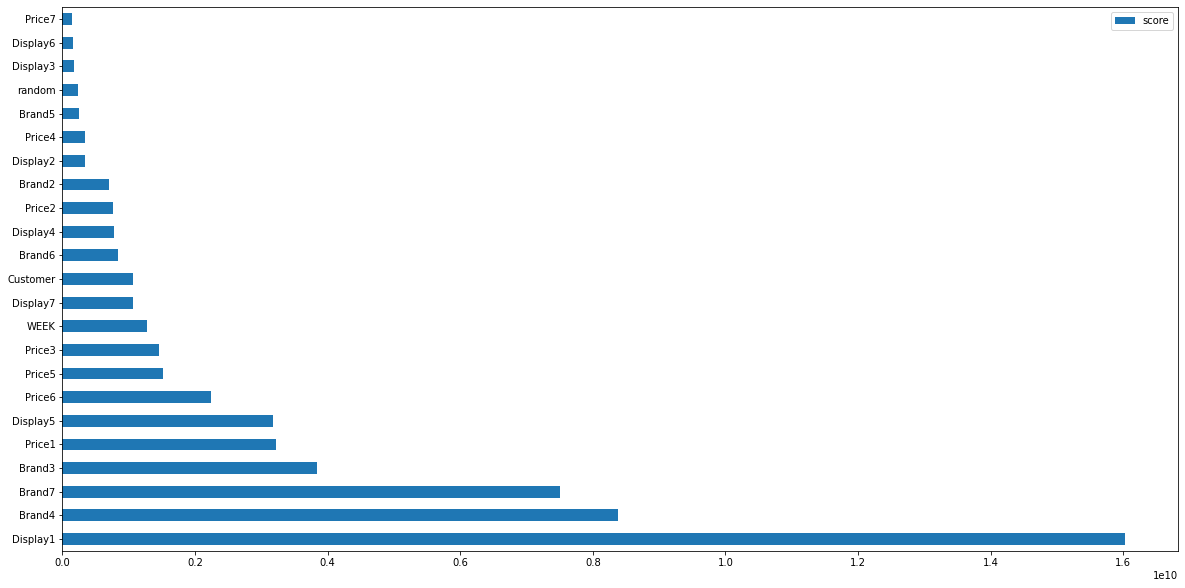

sq_mean_squared_error 2585913373.6388283
mean_squared_error 50851.876795638804
mean_absolute_error 24008.763492851125
r2_score -11.343065585867853
mean_absolute_percentage_error 2.5425878941860445
mean true 16432.221492075736


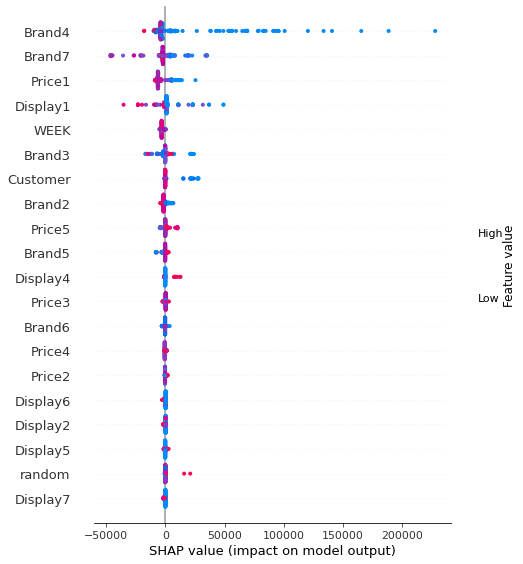

Brand2


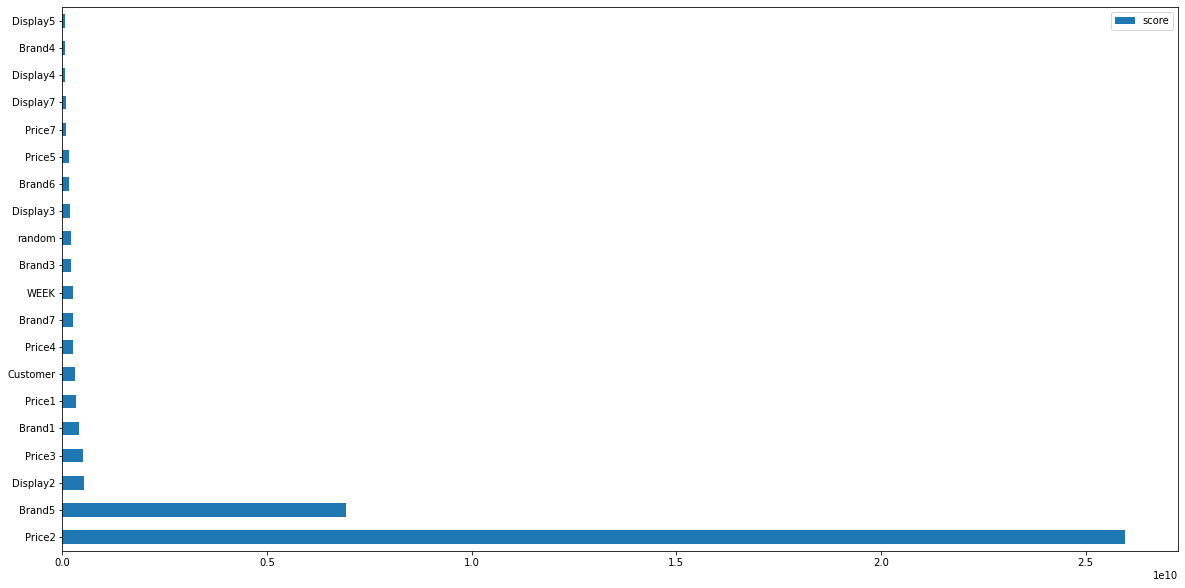

sq_mean_squared_error 598453073.0842297
mean_squared_error 24463.300535378086
mean_absolute_error 8891.978052991182
r2_score -2.793329756744187
mean_absolute_percentage_error 0.7381022118628994
mean true 12198.420088608738


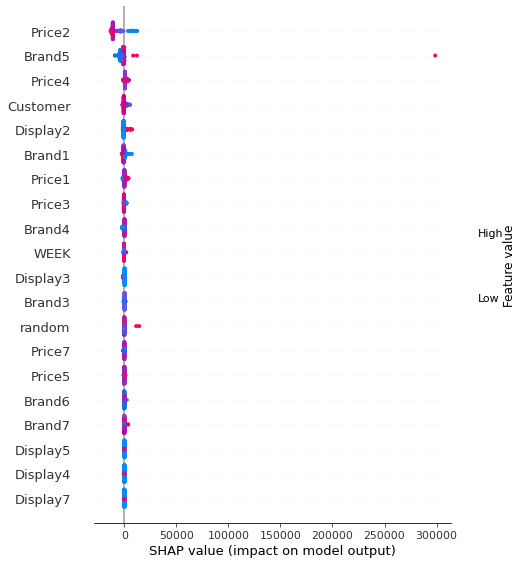

Brand3


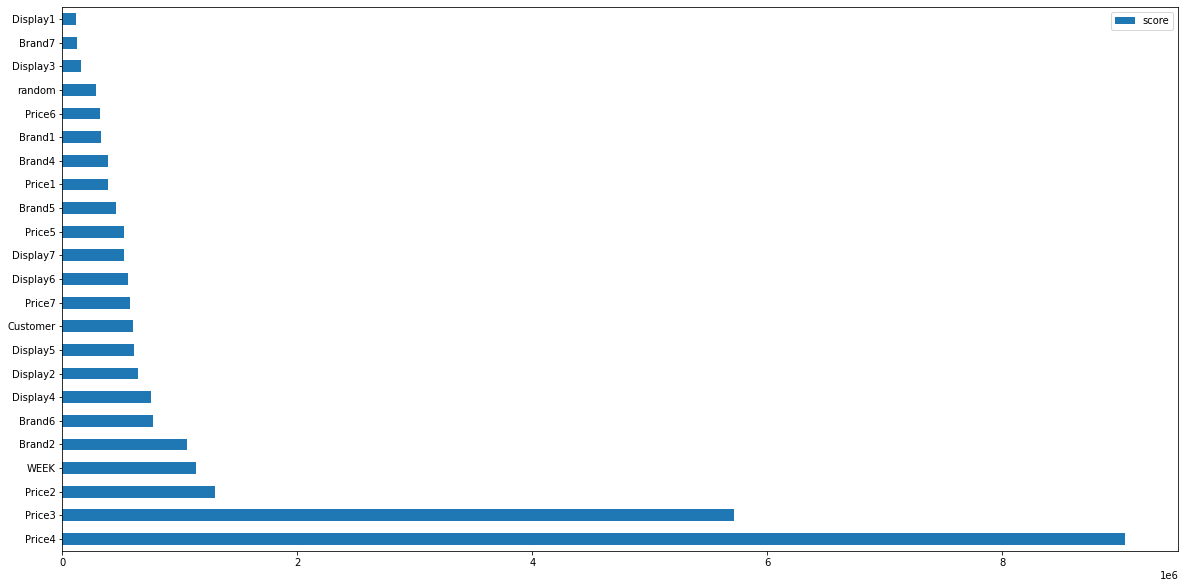

sq_mean_squared_error 679279.9747491514
mean_squared_error 824.1844300574668
mean_absolute_error 460.1909167564315
r2_score 0.30960131792494705
mean_absolute_percentage_error 0.1486338682045479
mean true 2773.429900984214


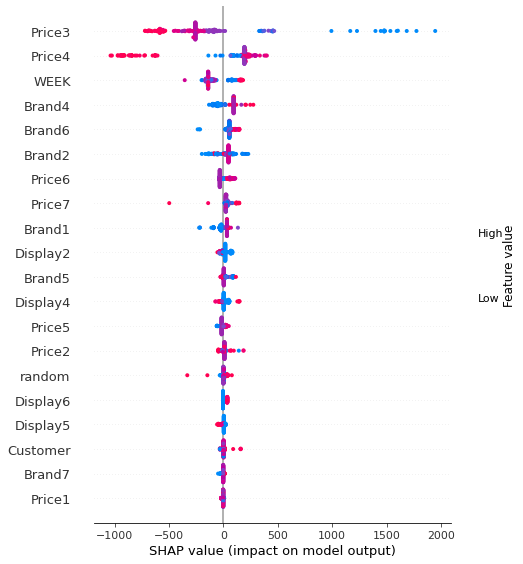

Brand4


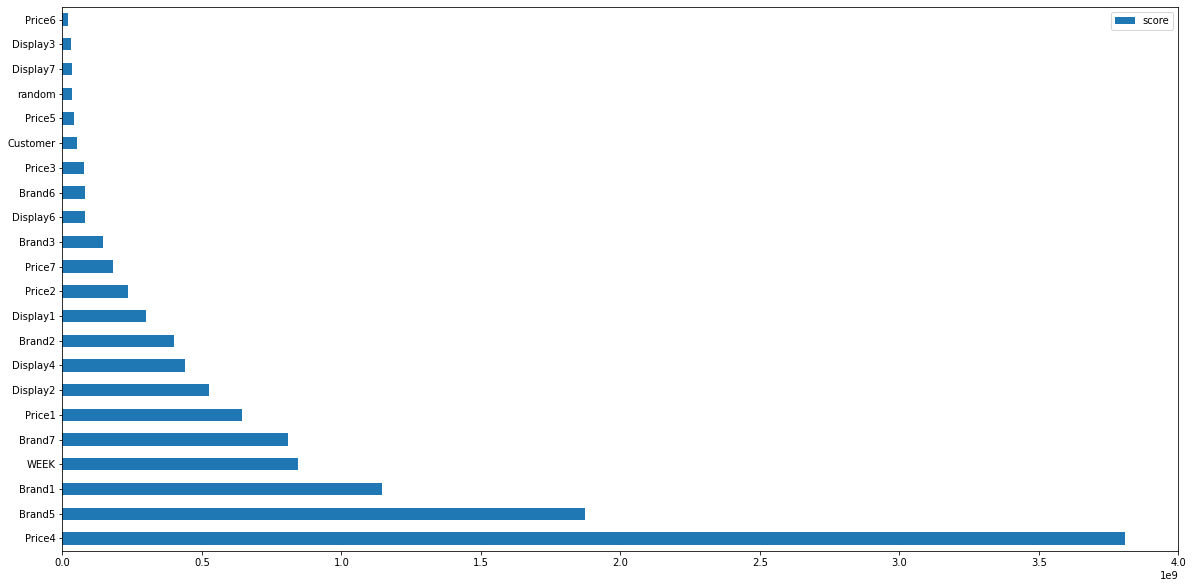

sq_mean_squared_error 745047939.9636797
mean_squared_error 27295.566305971373
mean_absolute_error 11625.797636938565
r2_score 0.3054371277405269
mean_absolute_percentage_error 1.4069654800303004
mean true 13413.234932056726


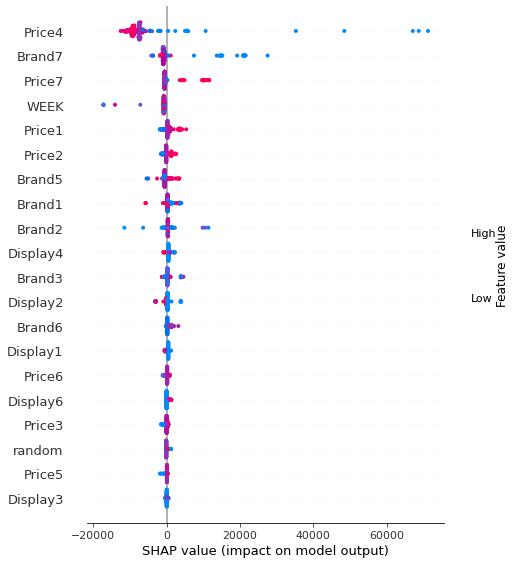

Brand5


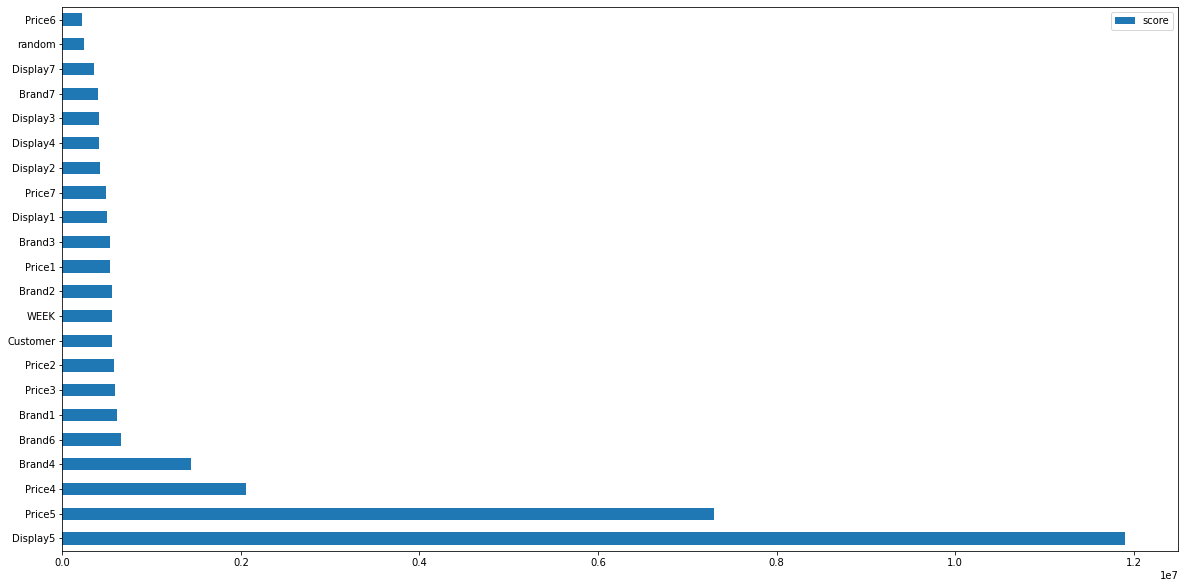

sq_mean_squared_error 749052.5741340078
mean_squared_error 865.4782343502393
mean_absolute_error 577.2874542905099
r2_score 0.1063716742221702
mean_absolute_percentage_error 0.2441895540386657
mean true 2701.143736433648


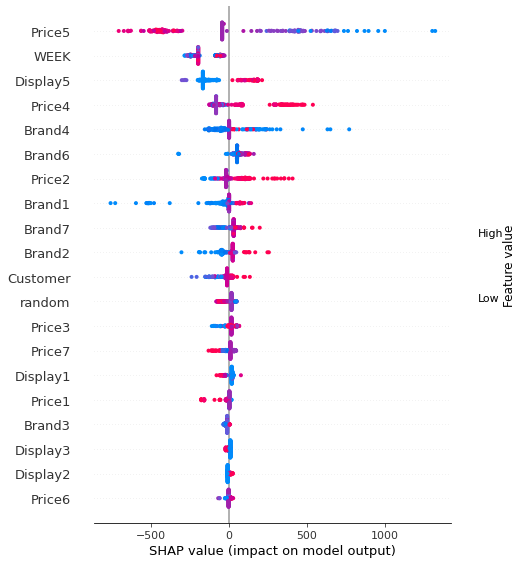

Brand6


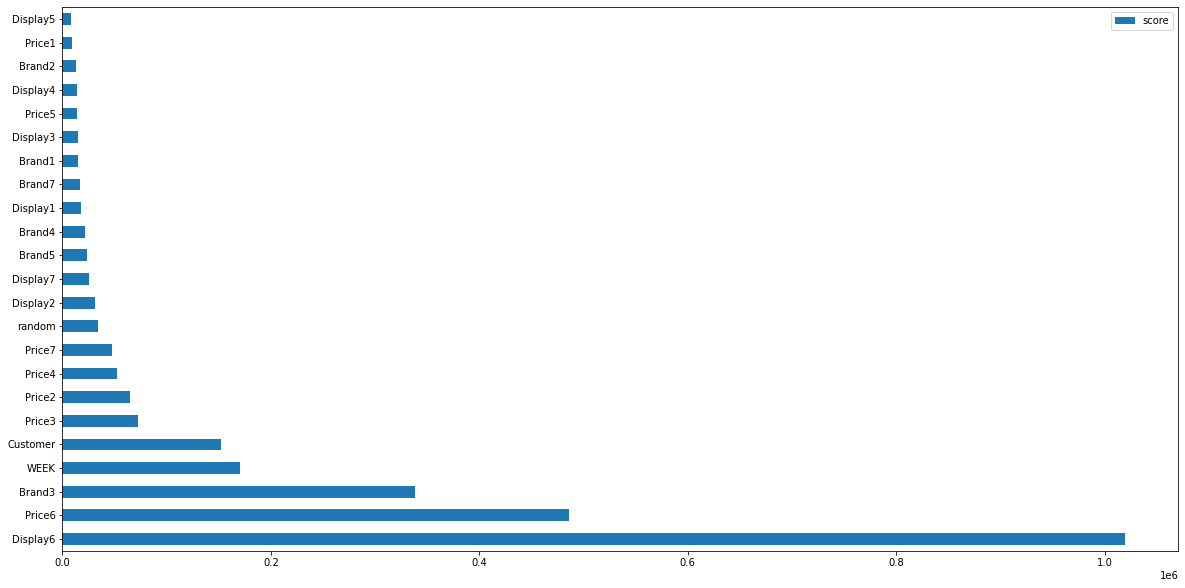

sq_mean_squared_error 234757.73940620184
mean_squared_error 484.5180485866361
mean_absolute_error 414.90769748563537
r2_score -2.252299506129135
mean_absolute_percentage_error 0.38058417142456463
mean true 1210.9743688858491


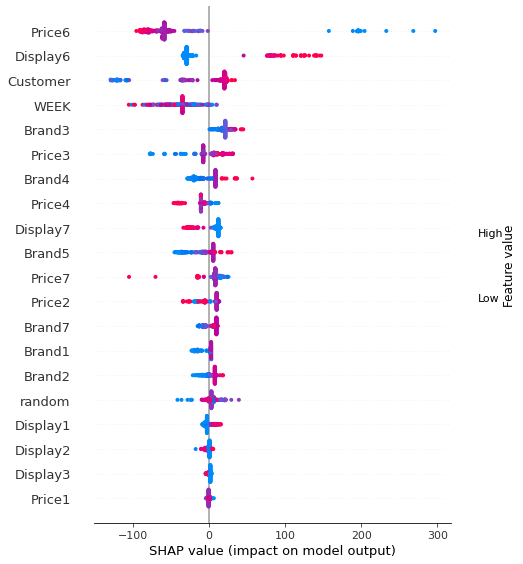

Brand7


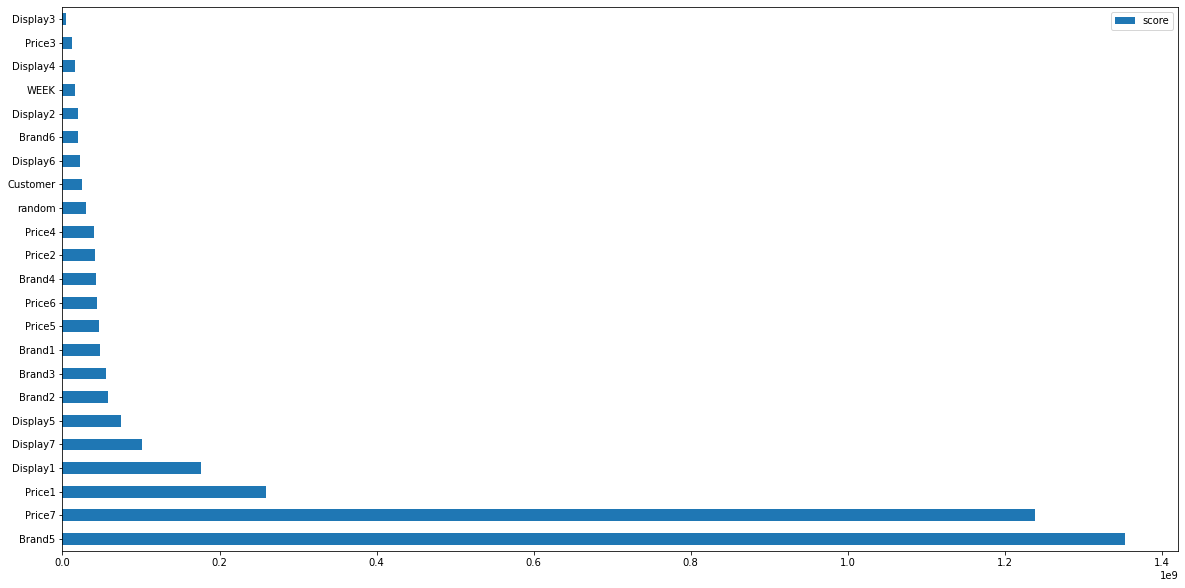

sq_mean_squared_error 176877562.4515262
mean_squared_error 13299.53241477031
mean_absolute_error 5822.262153108483
r2_score -7.268572904975867
mean_absolute_percentage_error 1.2500634722677095
mean true 7541.769855193133


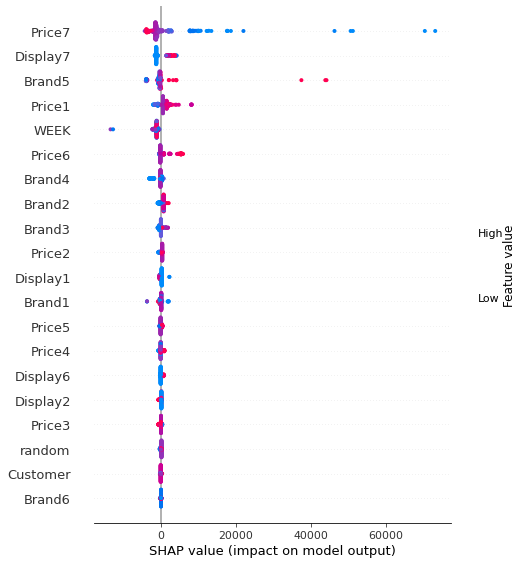

In [ ]:
for i in ['Brand1', 'Brand2', 'Brand3', 'Brand4', 'Brand5', 'Brand6', 'Brand7']:
  print(i)
  calc_effect(df, column_name = i)

In [ ]:
# (2) Calculate the effect of different prices and promotions on number of customers

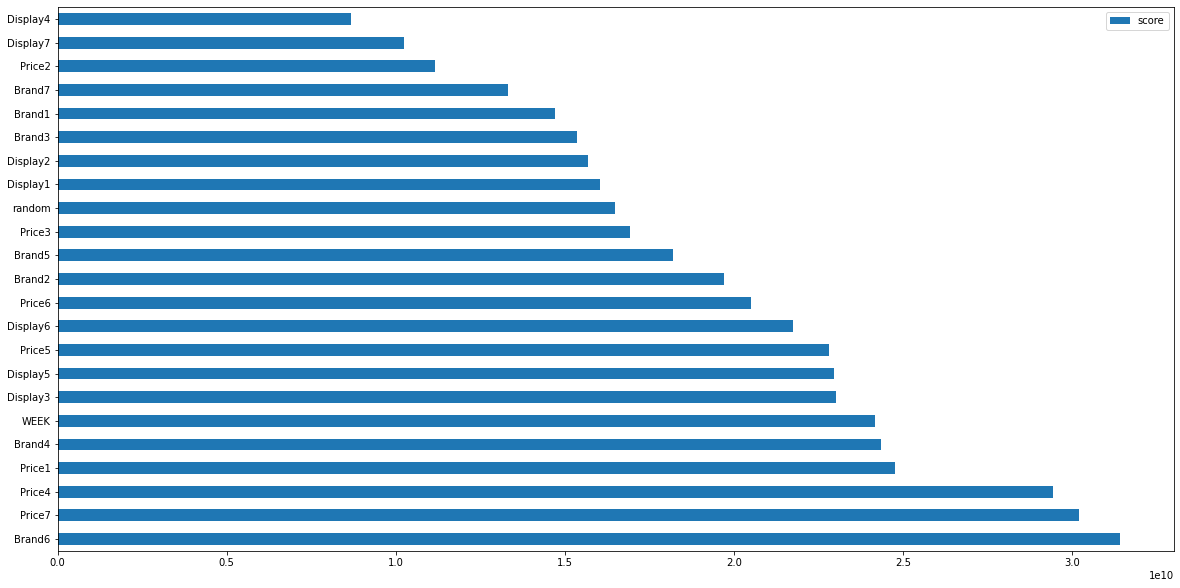

sq_mean_squared_error 83856867909.42857
mean_squared_error 289580.5033309884
mean_absolute_error 237478.59710163242
r2_score -1.7685499709455819
mean_absolute_percentage_error 0.13585747022328787
mean true 1893125.3583003767


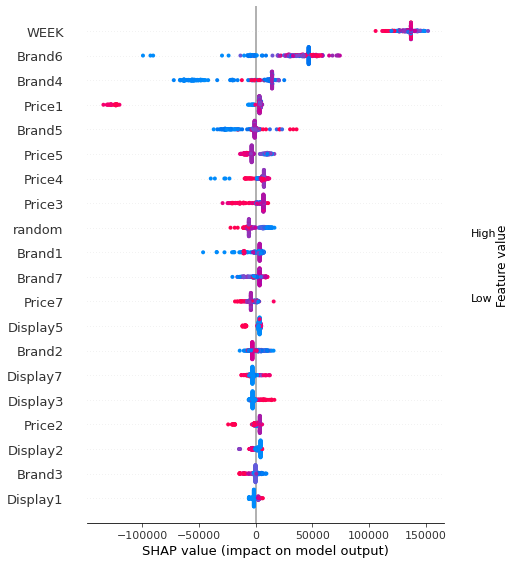

In [ ]:
calc_effect(df, column_name = 'Customer')

In [ ]:
# (3) Identify seasonal effects within each year per brand (assume 52 weeks per year)

#Timeseries Analysis

In [ ]:
# Multiplicative Decomposition 

#y(t) = Level * Trend * Seasonality * Noise

def ident_seasonal(df, column_name='Brand1'):
  result_mul = seasonal_decompose(df[column_name], model='multiplicative', extrapolate_trend='freq')

  # Additive Decomposition
#y(t) = Level + Trend + Seasonality + Noise


  #result_add = seasonal_decompose(df[column_name], model='additive', extrapolate_trend='freq')

  # Plot
  plt.rcParams.update({'figure.figsize': (10,10)})
  result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
  #result_add.plot().suptitle('Additive Decompose', fontsize=22)
  plt.show()



Brand1


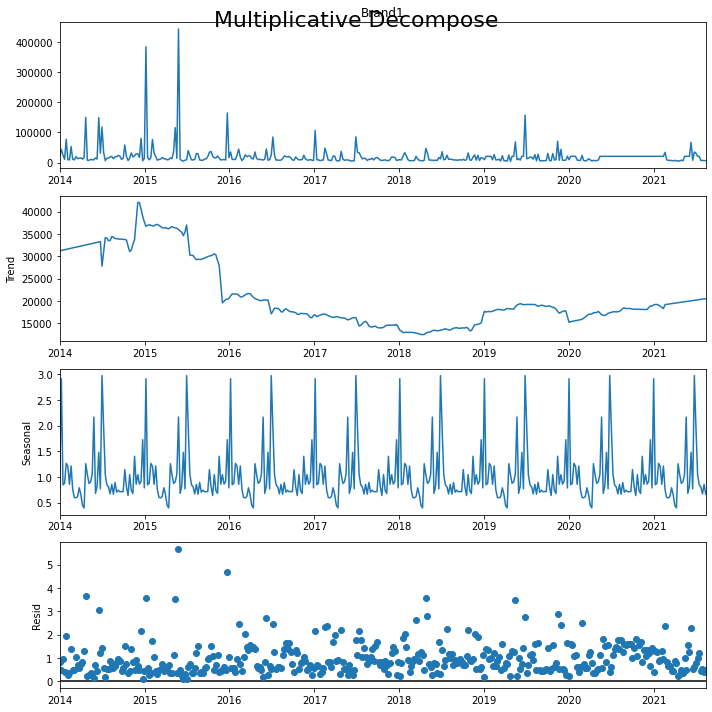

Brand2


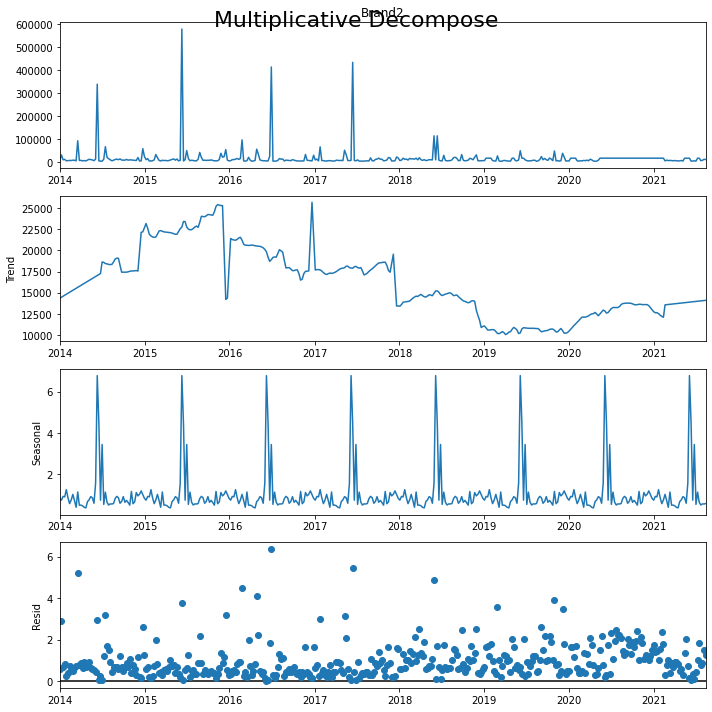

Brand3


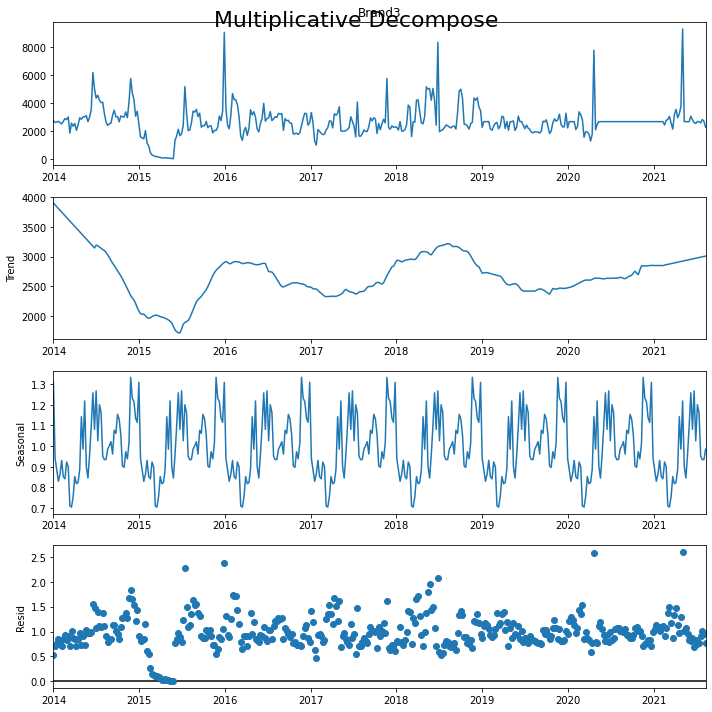

Brand4


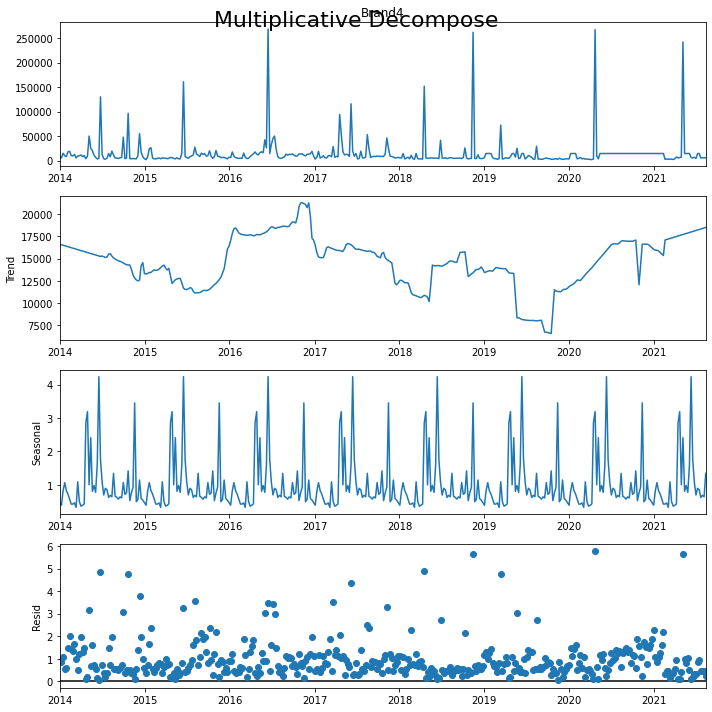

Brand5


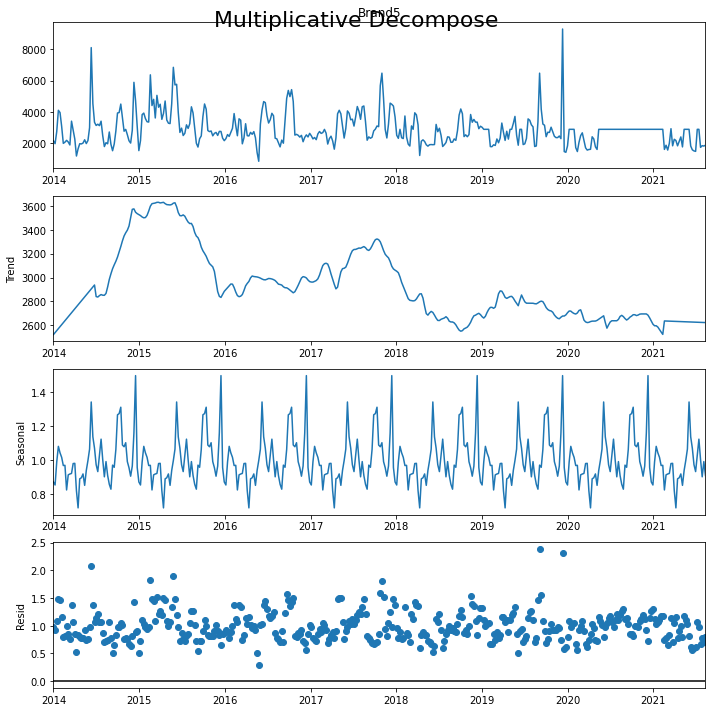

Brand6


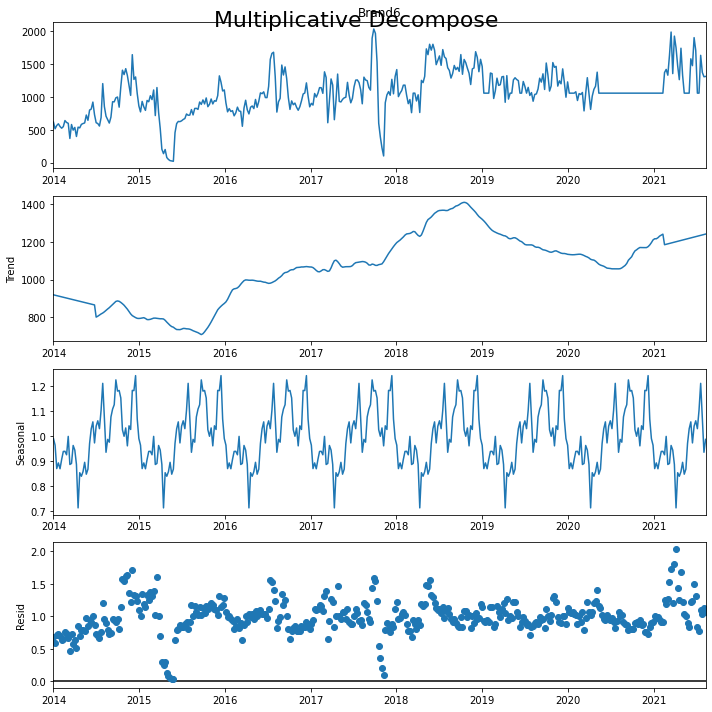

Brand7


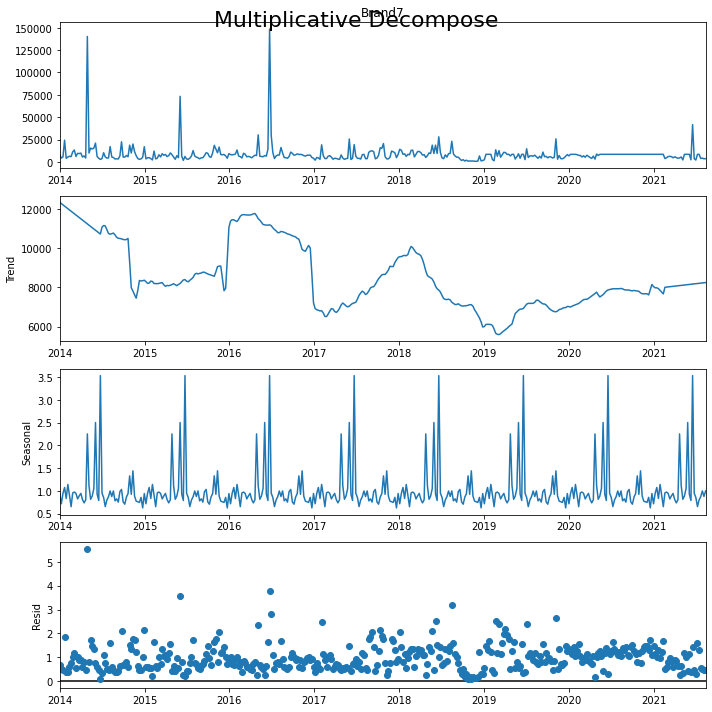

Customer


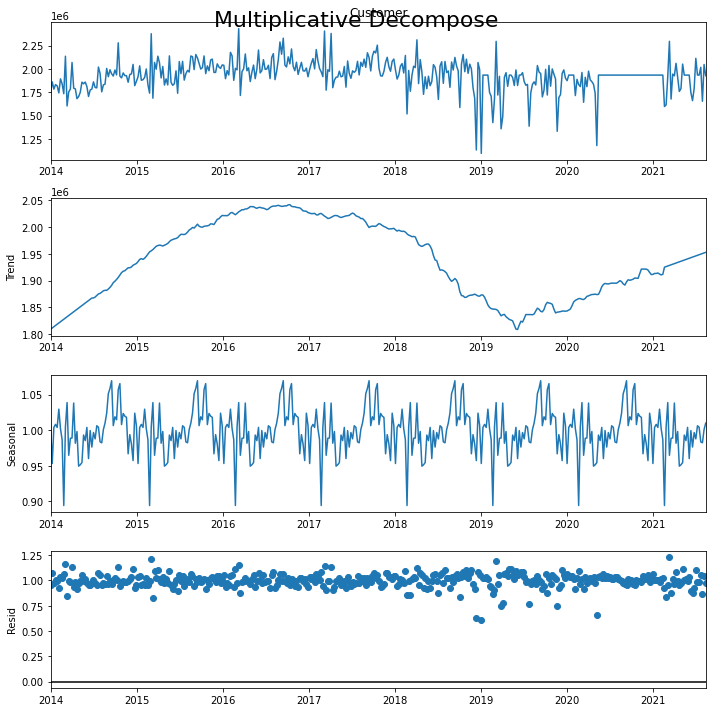

In [ ]:
for i in ['Brand1', 'Brand2', 'Brand3', 'Brand4', 'Brand5', 'Brand6', 'Brand7', 'Customer']:
  print(i)  
  ident_seasonal(df, column_name=i)
  

#Prophet

In [ ]:
def calc_prophet(df, column_name=i):  
  
  m = Prophet(seasonality_mode='multiplicative', interval_width=0.95 )
  df = df.rename(columns={'DATE':'ds', column_name:'y'})
  m.fit(df)
  future = m.make_future_dataframe(periods=52,freq='W')
  forecast = m.predict(future)
  fig = m.plot(forecast)
  a = add_changepoints_to_plot(fig.gca(), m, forecast)
  plt.show()
  fig = m.plot(forecast)
  plt.show()
  fig = m.plot_components(forecast)
  

In [ ]:
df_prophet = df.reset_index()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Brand1


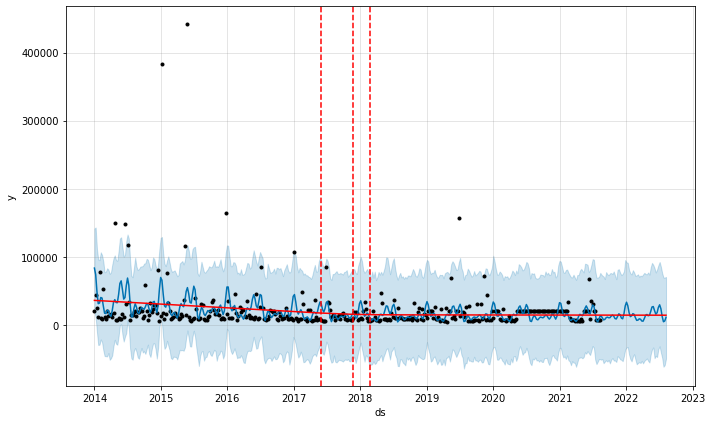

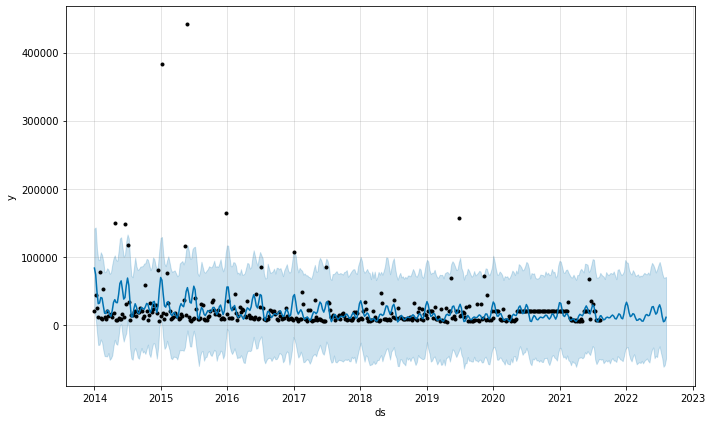

FixedFormatter should only be used together with FixedLocator


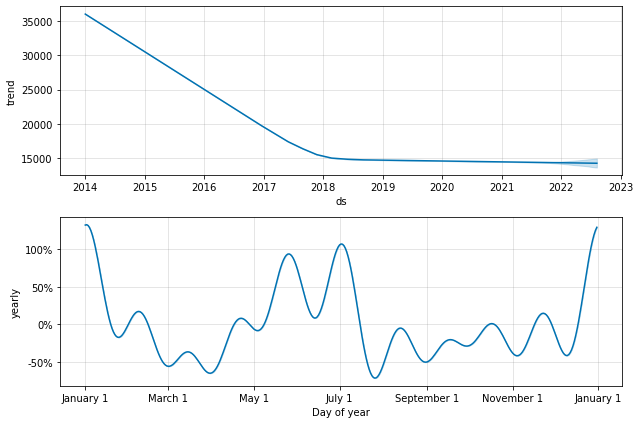

In [ ]:
for i in ['Brand1', 'Brand2', 'Brand3', 'Brand4', 'Brand5', 'Brand6', 'Brand7']:
  print(i)  
  df_fc = calc_prophet(df_prophet)
  break

# Vorbereitung von Funktionen


In [ ]:
def forecast_prophet(df, column_name=i, period_week=12):  
  df = df.rename(columns={'DATE':'ds', column_name:'y'})
  train = df[:199]
  test = df[199:199+period_week]

  
  m = Prophet(seasonality_mode='multiplicative', interval_width=0.95 )
  
  m.fit(train)
  #future = m.make_future_dataframe(periods=52,freq='W')
  forecast = m.predict(test)
  forecast = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].rename(
        columns={
            'yhat_lower':'predicted_lower_bound'
            ,'yhat_upper':'predicted_upper_bound'
            #, 'ds':'dates'
        })
  orbit = pd.merge(test[['ds', 'y']], forecast, on='ds', how='left')
  return orbit

In [ ]:

def calculate_intersection(lower_bound, upper_bound, predicted_lower_bound, predicted_upper_bound):
    intersection = 0
    if upper_bound < predicted_lower_bound or lower_bound > predicted_upper_bound :
        intersection = 0
    elif lower_bound <= predicted_lower_bound : 
        if upper_bound <= predicted_upper_bound:
            intersection = upper_bound - predicted_lower_bound
        elif upper_bound > predicted_upper_bound:
            intersection = predicted_upper_bound - predicted_lower_bound
    elif lower_bound > predicted_lower_bound:
        if upper_bound >= predicted_upper_bound:
            intersection = predicted_upper_bound - lower_bound
        elif upper_bound < predicted_upper_bound:
            intersection = upper_bound - lower_bound
    return intersection

def calculate_union(lower_bound, upper_bound, predicted_lower_bound, predicted_upper_bound):
    min_ = np.min([lower_bound, upper_bound, predicted_lower_bound, predicted_upper_bound])
    max_ = np.max([lower_bound, upper_bound, predicted_lower_bound, predicted_upper_bound])
    return max_ - min_



def return_metrics(orbit):
  orbit['intersection'] = orbit.apply(lambda x: calculate_intersection(x.lower_bound, x.upper_bound
                                               , x.predicted_lower_bound, x.predicted_upper_bound), axis=1)
  orbit['union'] = orbit.apply(lambda x: calculate_union(x.lower_bound, x.upper_bound
                                                , x.predicted_lower_bound, x.predicted_upper_bound), axis=1)

  orbit['iou'] = orbit.intersection / orbit.union
  metric_iou = orbit['iou'].mean()

  metric_mape = mean_absolute_percentage_error(y_true=orbit['y'],
                   y_pred=orbit['yhat'])
  
  m_mean_squared_error = mean_squared_error(orbit['y'], orbit['yhat'], squared=False)
  m_mean_absolute_error = mean_absolute_error(orbit['y'], orbit['yhat'])
  m_r2 = r2_score(orbit['y'], orbit['yhat'])
  m_mape_sk = mean_absolute_percentage_error(orbit['y'], orbit['yhat'])
  #m_mean_squared_log_error = mean_squared_log_error(orbit['y'], orbit['yhat'])
  return metric_iou, metric_mape, m_mean_squared_error, m_mean_absolute_error, m_r2, m_mape_sk#, m_mean_squared_log_error

#Vorhersage

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Brand1
12


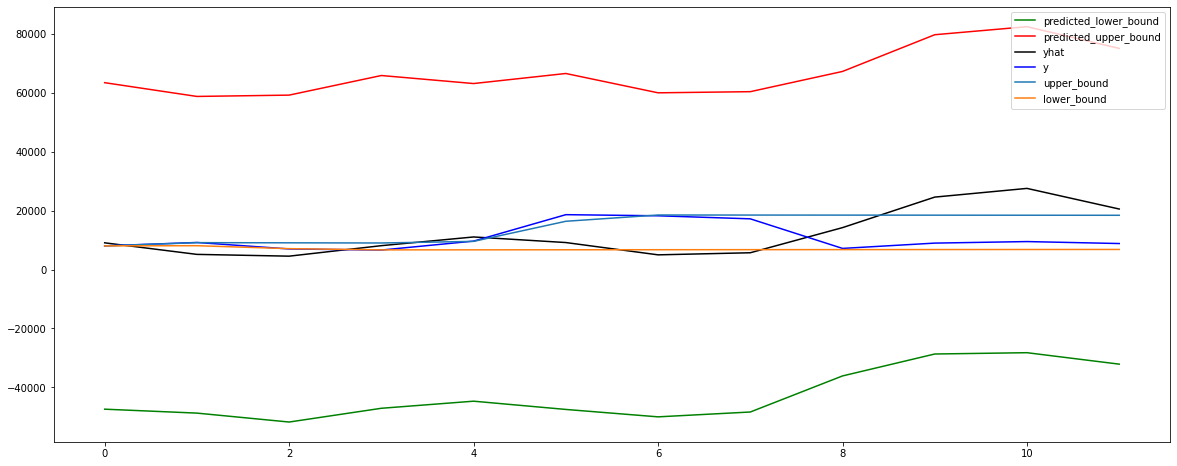

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.06743101625217356
Brand2
12


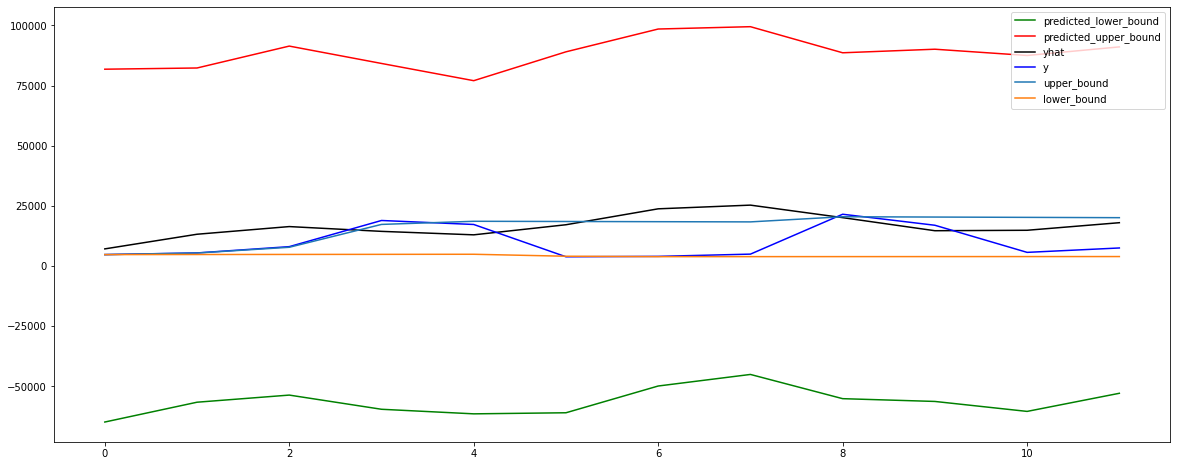

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.0795513128235742
Brand3
12


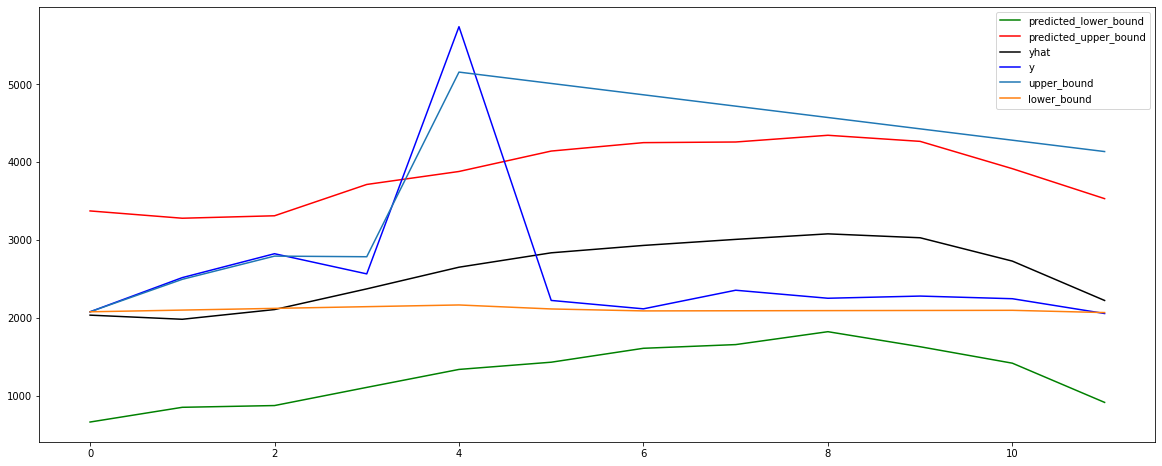

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.4796068611446494
Brand4
12


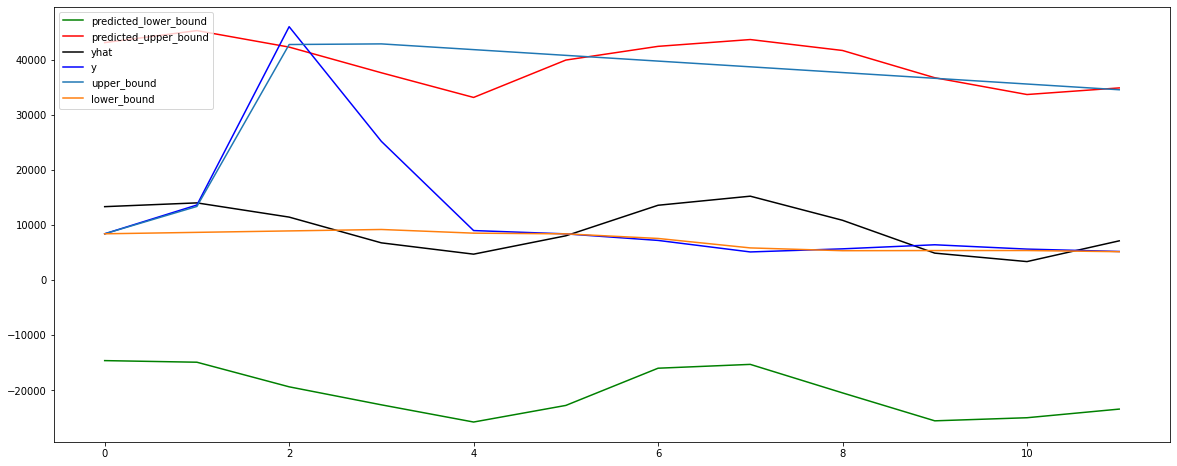

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.4177279707936414
Brand5
12


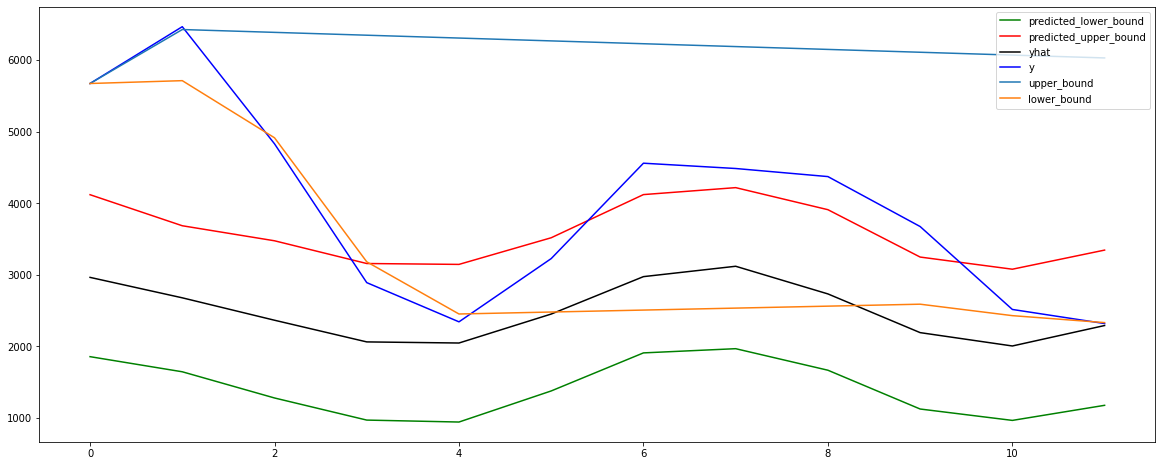

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.15686018268178417
Brand6
12


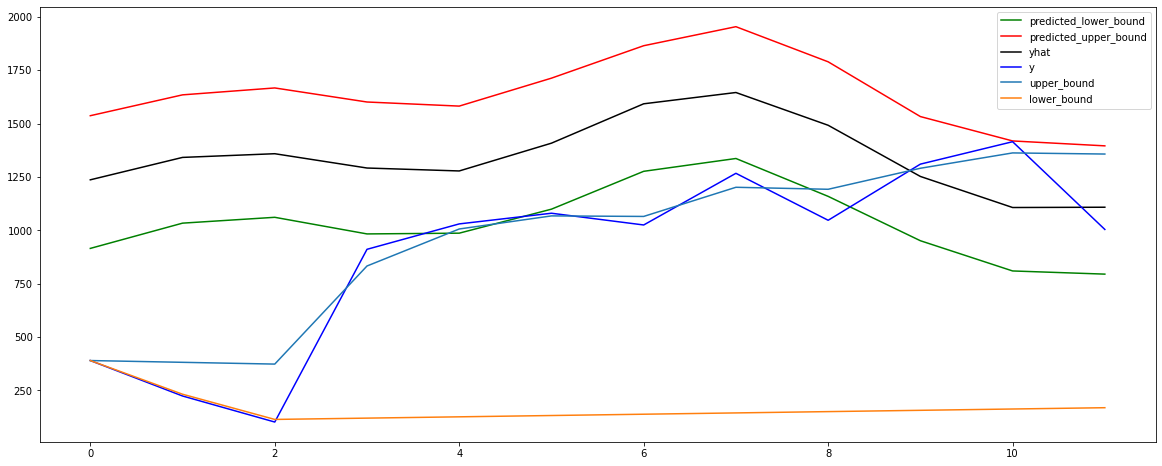

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.09828216508240721
Brand7
12


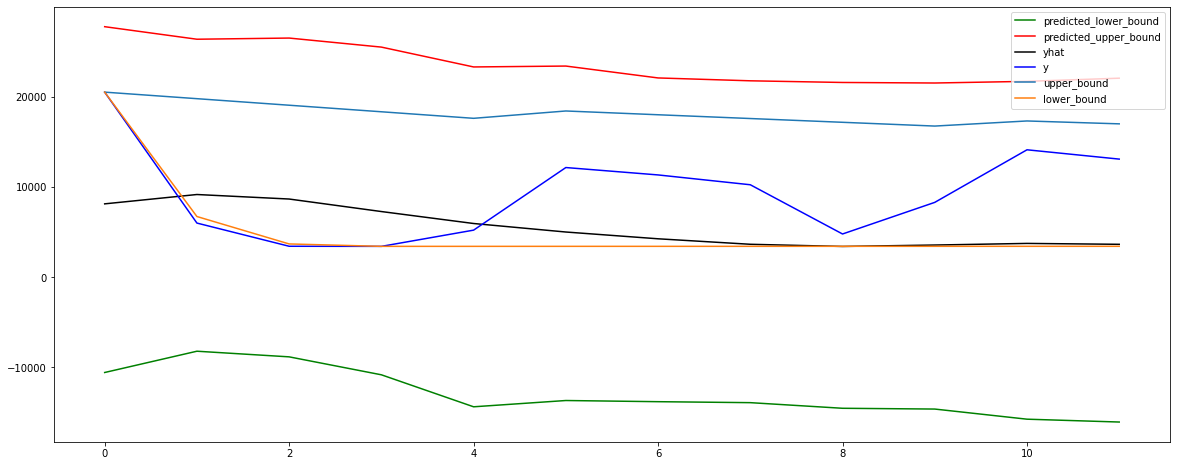

0.3571014316394932


In [ ]:
mapes=[]
ious=[]
brands=[]
periods=[]
m_mean_squared_errors=[]
m_mean_absolute_errors=[]
m_r2s=[] 
m_mape_sks=[]
m_mean_squared_log_errors=[]
for i in ['Brand1', 'Brand2', 'Brand3', 'Brand4', 'Brand5', 'Brand6', 'Brand7']:

  for period_week in [12]:

    print(i)  
    brands.append(i)
    periods.append(period_week)
    print(period_week)  
    orbit = forecast_prophet(df_prophet, column_name=i, period_week=period_week)
    

    val_list=orbit.y.values
    vals=[]
    perc=[]

    for r in range(len(val_list)):
        l=[x for x in val_list[0:r+1]]
        vals.append(l)

    for value in vals:
        perc.append(np.percentile(value,95)) 
    orbit['upper_bound']=perc

    val_list=orbit.y.values
    vals=[]
    perc=[]
    for r in range(len(val_list)):
        l=[x for x in val_list[0:r+1]]
        vals.append(l)

    for value in vals:
        perc.append(np.percentile(value,5)) 
    orbit['lower_bound']=perc
    
  #########Plot

    orbit['predicted_lower_bound'].plot(legend=True, figsize=(20,8), color='green')
    orbit['predicted_upper_bound'].plot(legend=True, figsize=(20,8), color='red')
    orbit['yhat'].plot(legend=True, figsize=(20,8), color='black')
    orbit['y'].plot(legend=True, figsize=(20,8), color='blue')
    orbit['upper_bound'].plot(legend=True, figsize=(20,8))
    orbit['lower_bound'].plot(legend=True, figsize=(20,8))
    plt.show()
    
    m_iou, m_mape, m_mean_squared_error, m_mean_absolute_error, m_r2, m_mape_sk = return_metrics(orbit)

    #print(m_mape)
    mapes.append(m_mape)
    print(m_iou)
    ious.append(m_iou)
    m_mean_squared_errors.append(m_mean_squared_error)
    m_mean_absolute_errors.append(m_mean_absolute_error)
    m_r2s.append(m_r2)
    m_mape_sks.append(m_mape_sk)
    #m_mean_squared_log_errors.append(m_mean_squared_log_error)
    
  ##########Metrics

  

ds        y         yhat  ...  intersection         union       iou
0 2017-10-25  20540.0  8143.664079  ...          0.00  38369.967792  0.000000
1 2017-11-01   6012.0  9180.438489  ...      13075.20  34617.135052  0.377709
2 2017-11-08   3439.0  8679.038791  ...      15390.90  35371.889479  0.435117
3 2017-11-15   3426.0  7290.617839  ...      14932.85  36360.225531  0.410692
4 2017-11-22   5227.0  5963.700682  ...      14205.80  37707.564517  0.376736

[5 rows x 10 columns]

<AxesSubplot:xlabel='brand', ylabel='m_iou'>

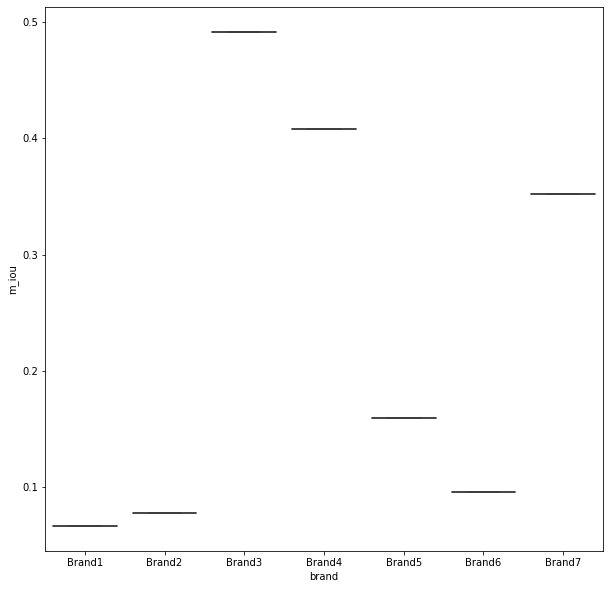

In [ ]:
df_metrics = pd.DataFrame({'brand': brands, 'm_mape': mapes,'m_iou': ious, 'periods': periods,
                           
                           'm_mean_squared_errors': m_mean_squared_errors, 
                       'm_mean_absolute_errors': m_mean_absolute_errors,
                        'm_r2s': m_r2s,
                        'm_mape_sks': m_mape_sks
                      })
#df_metrics.index = df_metrics.periods
#df_metrics = df_metrics.drop('periods', axis=1)
#for i in df_metrics['brand']:

sns.boxplot(x=df_metrics['brand'], y=df_metrics['m_iou'] )
 # break


In [ ]:
df_metrics

brand    m_mape     m_iou  ...  m_mean_absolute_errors     m_r2s  m_mape_sks
0  Brand1  0.763020  0.066779  ...             8084.488476 -4.288854    0.763020
1  Brand2  1.603285  0.078266  ...             8675.765841 -1.774775    1.603285
2  Brand3  0.252504  0.491410  ...              740.234550 -0.184787    0.252504
3  Brand4  0.616977  0.407970  ...             7531.314322 -0.101761    0.616977
4  Brand5  0.322697  0.159447  ...             1456.368245 -0.939478    0.322697
5  Brand6  1.840497  0.095929  ...              503.225335 -1.293511    1.840497
6  Brand7  0.674351  0.352193  ...             6017.384531 -0.942820    0.674351

[7 rows x 8 columns]

<AxesSubplot:xlabel='brand', ylabel='m_mean_squared_errors'>

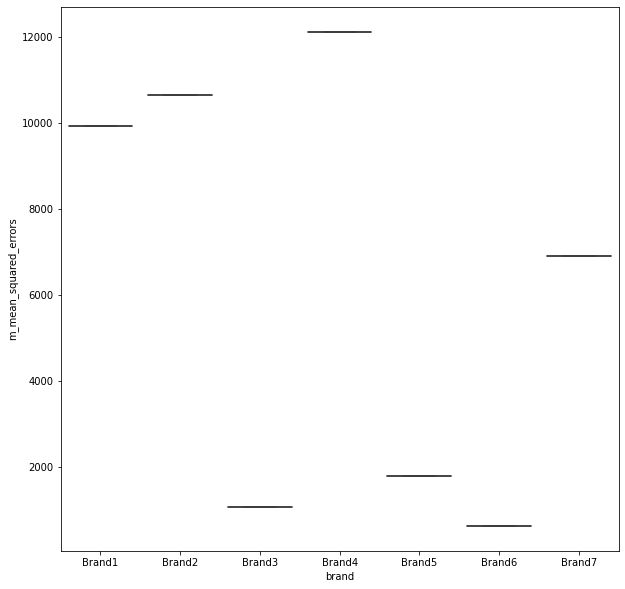

In [ ]:
sns.boxplot(x=df_metrics['brand'], y=df_metrics['m_mean_squared_errors'] )

<AxesSubplot:xlabel='brand', ylabel='m_mape'>

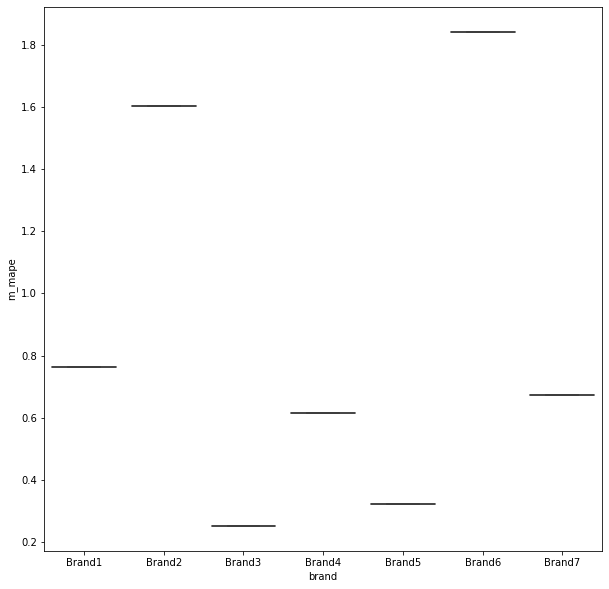

In [ ]:
sns.boxplot(x=df_metrics['brand'], y=df_metrics['m_mape'] )

In [ ]:
# (4) Split the data into two periods (Period 1: First 199 weeks) and predict the sales per brand for the second
#period. Use at least two different statistical methods for sales prediction and evaluate the suitability of
#each method.

#Feature Engineering

In [ ]:
def calc_stats(df,  calc = 'mean', column_name = 'Brand1'):

    if calc == 'mean':
        column_name_stats='mean'
        df[column_name+'_'+column_name_stats+'_1M'] = df[column_name].rolling(4).mean().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_2W'] = df[column_name].rolling(2).mean().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3W'] = df[column_name].rolling(3).mean().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3M'] = df[column_name].rolling(12).mean().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_6M'] = df[column_name].rolling(24).mean().shift(1).fillna(-999)
    if calc == 'sum':
        column_name_stats='sum'
        df[column_name+'_'+column_name_stats+'_1M'] = df[column_name].rolling(4).sum().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_2W'] = df[column_name].rolling(2).sum().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3W'] = df[column_name].rolling(3).sum().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3M'] = df[column_name].rolling(12).sum().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_6M'] = df[column_name].rolling(24).sum().shift(1).fillna(-999)
    if calc == 'std':
        column_name_stats='std'
        df[column_name+'_'+column_name_stats+'_1M'] = df[column_name].rolling(4).std().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_2W'] = df[column_name].rolling(2).std().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3W'] = df[column_name].rolling(3).std().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3M'] = df[column_name].rolling(12).std().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_6M'] = df[column_name].rolling(24).std().shift(1).fillna(-999)
        
    if calc == 'var':
        column_name_stats='var'
        df[column_name+'_'+column_name_stats+'_1M'] = df[column_name].rolling(4).var().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_2W'] = df[column_name].rolling(2).var().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3W'] = df[column_name].rolling(3).var().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3M'] = df[column_name].rolling(12).var().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_6M'] = df[column_name].rolling(24).var().shift(1).fillna(-999)   
   
    if calc == 'min':
        column_name_stats='min'
        df[column_name+'_'+column_name_stats+'_1M'] = df[column_name].rolling(4).min().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_2W'] = df[column_name].rolling(2).min().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3W'] = df[column_name].rolling(3).min().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3M'] = df[column_name].rolling(12).min().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_6M'] = df[column_name].rolling(24).min().shift(1).fillna(-999)
    if calc == 'max':
        column_name_stats='max'
        df[column_name+'_'+column_name_stats+'_1M'] = df[column_name].rolling(4).max().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_2W'] = df[column_name].rolling(2).max().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3W'] = df[column_name].rolling(3).max().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3M'] = df[column_name].rolling(12).max().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_6M'] = df[column_name].rolling(24).max().shift(1).fillna(-999)
    if calc == 'median':
        column_name_stats='median'
        df[column_name+'_'+column_name_stats+'_1M'] = df[column_name].rolling(4).median().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_2W'] = df[column_name].rolling(2).median().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3W'] = df[column_name].rolling(3).median().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_3M'] = df[column_name].rolling(12).median().shift(1).fillna(-999)
        df[column_name+'_'+column_name_stats+'_6M'] = df[column_name].rolling(24).median().shift(1).fillna(-999)


    return df

In [ ]:
df_brand = df[['WEEK', 'Brand1', 'Price1', 'Display1']]
df_brand

WEEK        Brand1    Price1  Display1
DATE                                              
2014-01-01     1  20347.000000  0.913805       0.0
2014-01-08     2  44351.000000  0.753283       0.0
2014-01-15     3  25177.000000  0.753157       0.0
2014-01-22     4  11032.000000  0.918930       0.0
2014-01-29     5  77269.000000  0.690000       1.0
...          ...           ...       ...       ...
2021-07-14   394  20810.384615  0.804283       0.0
2021-07-21   395   7086.000000  0.951389       0.0
2021-07-28   396   7297.000000  0.957442       0.0
2021-08-04   397   6720.000000  0.957523       0.0
2021-08-11   398   6734.000000  0.957442       0.0

[398 rows x 4 columns]

In [ ]:
for i in ['Brand1']:
          #, 'Brand2', 'Brand3', 'Brand4', 'Brand5', 'Brand6',
       #'Brand7', , 'Display2', 'Display3', 'Display4', 'Display5',
       #'Display6', 'Display7',  'Price2', 'Price3', 'Price4',
       #'Price5', 'Price6', 'Price7', 'Customer']:
    for k in ['sum', 'mean', 'max', 'min', 'var', 'std', 'median']:
        
    
        df_brand = calc_stats(df_brand, calc =k, column_name =i)

KeyError: ignored

In [ ]:
pd.options.mode.chained_assignment = None 

# Xgboost mit einem Prüfmodul

Brand1
mean_squared_error 3873.794603763649
mean_absolute_error 3098.9486083984375
r2_score 0.19312887271530088
mean_absolute_percentage_error 0.33417227260143134
mean true 10732.416666666666


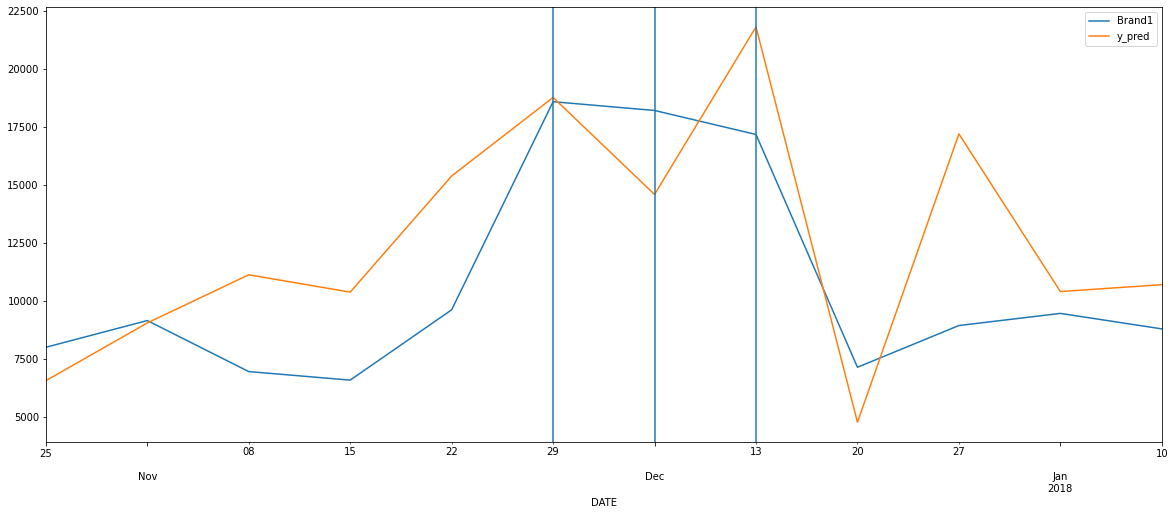

Brand2
mean_squared_error 78993.77534013816
mean_absolute_error 54413.88423665365
r2_score -151.93317757508282
mean_absolute_percentage_error 8.139604674302614
mean true 9889.833333333334


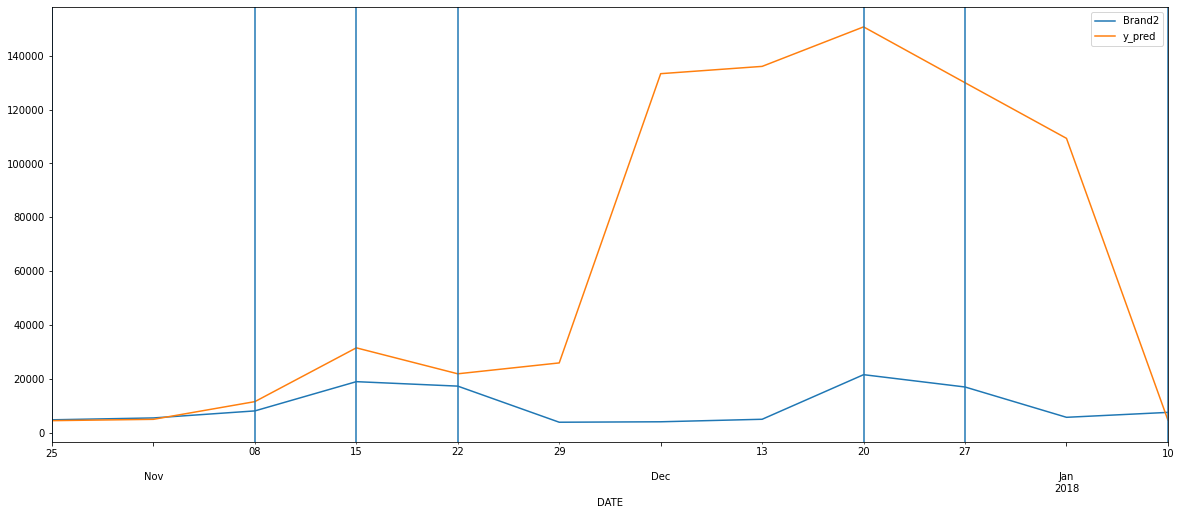

Brand3
mean_squared_error 350.26530398359245
mean_absolute_error 266.92144775390625
r2_score 0.8693738089885974
mean_absolute_percentage_error 0.09634004383039141
mean true 2604.4166666666665


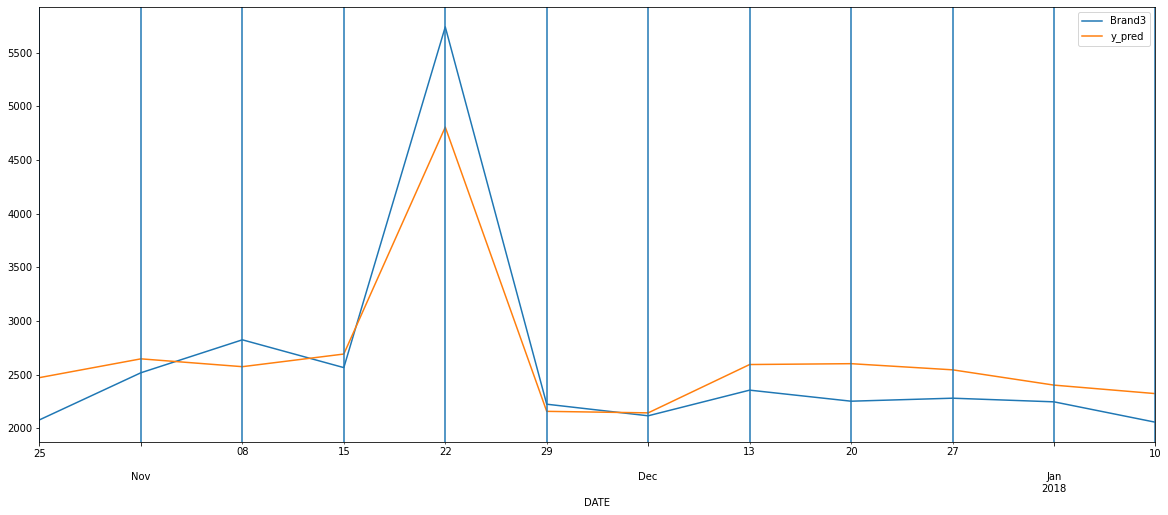

Brand4
mean_squared_error 7455.772172199864
mean_absolute_error 4724.435872395833
r2_score 0.5823531856586706
mean_absolute_percentage_error 0.42182089023197117
mean true 12160.666666666666


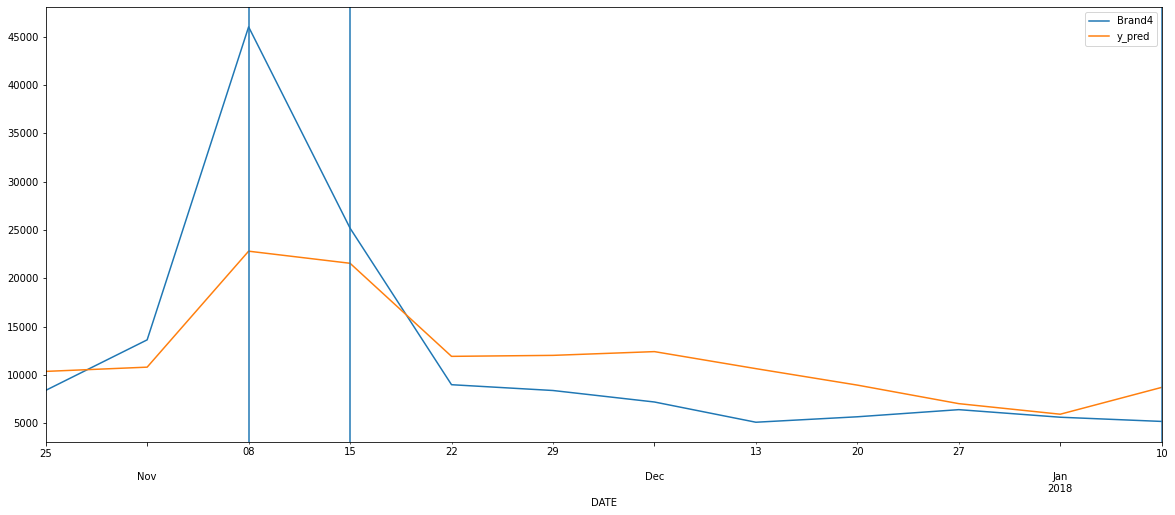

Brand5
mean_squared_error 1404.5620334967452
mean_absolute_error 1176.5859985351562
r2_score -0.1869007463520802
mean_absolute_percentage_error 0.268530842375991
mean true 3946.9166666666665


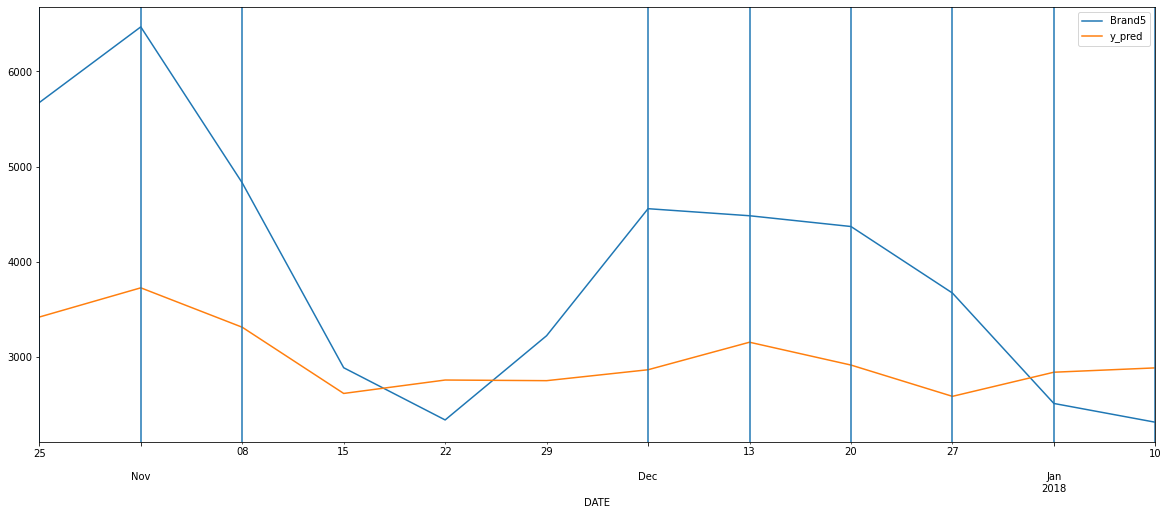

Brand6
mean_squared_error 446.82446257575543
mean_absolute_error 384.3467381795247
r2_score -0.18642626567992338
mean_absolute_percentage_error 0.49779541293754076
mean true 900.4166666666666


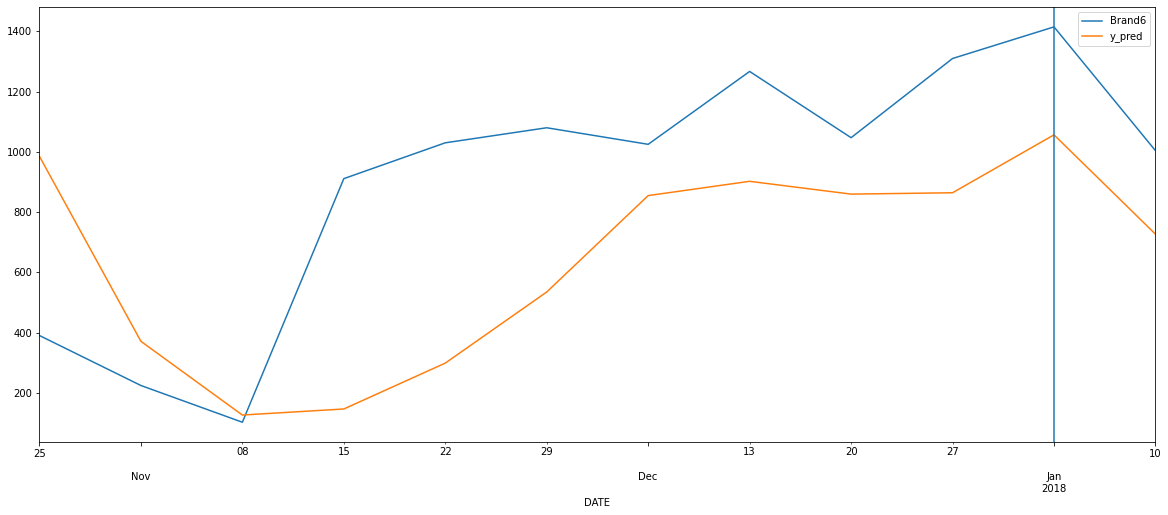

Brand7
mean_squared_error 5048.399196226331
mean_absolute_error 4372.7162679036455
r2_score -0.03652676799014953
mean_absolute_percentage_error 0.517855216361593
mean true 9399.333333333334


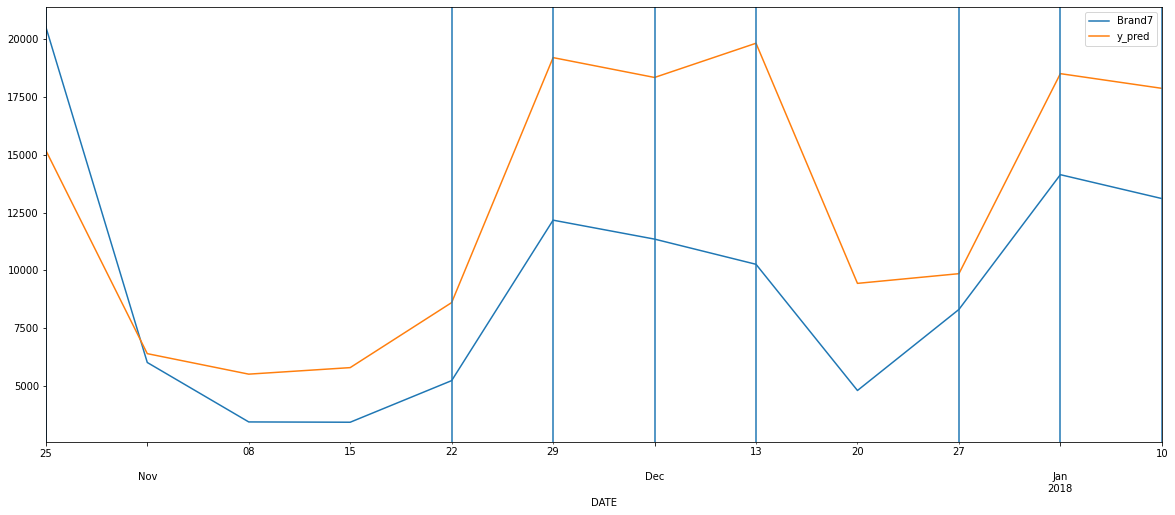

In [ ]:
mapes=[]
brands=[]
m_mean_squared_errors=[]
m_mean_absolute_errors=[]
m_r2s=[] 

mapes_pf=[]
brands_pf=[]
m_mean_squared_errors_pf=[]
m_mean_absolute_errors_pf=[]
m_r2s_pf=[] 
means=[]
for i in ['Brand1', 'Brand2', 'Brand3', 'Brand4', 'Brand5', 'Brand6', 'Brand7']:
  if i == 'Brand1':
    df_brand = df[['WEEK', 'Brand1', 'Price1', 'Display1']]
    for k in ['sum', 'mean', 'max', 'min', 'var', 'std', 'median']:
      df_brand = calc_stats(df_brand, calc =k, column_name =i)

  if i == 'Brand2':
    df_brand = df[['WEEK', 'Brand2', 'Price2', 'Display2']]
    for k in ['sum', 'mean', 'max', 'min', 'var', 'std', 'median']:
      df_brand = calc_stats(df_brand, calc =k, column_name =i)

  if i == 'Brand3':
    df_brand = df[['WEEK', 'Brand3', 'Price3', 'Display3']]
    for k in ['sum', 'mean', 'max', 'min', 'var', 'std', 'median']:
      df_brand = calc_stats(df_brand, calc =k, column_name =i)

  if i == 'Brand4':
    df_brand = df[['WEEK', 'Brand4', 'Price4', 'Display4']]
    for k in ['sum', 'mean', 'max', 'min', 'var', 'std', 'median']:
      df_brand = calc_stats(df_brand, calc =k, column_name =i) 
  
  if i == 'Brand5':
    df_brand = df[['WEEK', 'Brand5', 'Price5', 'Display5']]
    for k in ['sum', 'mean', 'max', 'min', 'var', 'std', 'median']:
      df_brand = calc_stats(df_brand, calc =k, column_name =i)

  if i == 'Brand6':
    df_brand = df[['WEEK', 'Brand6', 'Price6', 'Display6']]
    for k in ['sum', 'mean', 'max', 'min', 'var', 'std', 'median']:
      df_brand = calc_stats(df_brand, calc =k, column_name =i)

  if i == 'Brand7':
    df_brand = df[['WEEK', 'Brand7', 'Price7', 'Display7']]
    for k in ['sum', 'mean', 'max', 'min', 'var', 'std', 'median']:
      df_brand = calc_stats(df_brand, calc =k, column_name =i)
  print(i)
  



  brands.append(i)
  train = df_brand[:199]
  test = df_brand[199:199+12]

  X_train = train.drop([i], axis=1)
  X_test = test.drop([i], axis=1)

  y_train = train[i]
  y_test = test[i]


  regr = xgb.XGBRegressor(objective ='reg:squarederror')
  #X_training, X_test, y_training, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=7)

  regr.fit(X_train, y_train)

  y_pred = regr.predict(X_test)

  #accuracy_score(y_test, y_pred)

  print('mean_squared_error', mean_squared_error(y_test, y_pred, squared=False))
  m_mean_squared_errors.append(mean_squared_error(y_test, y_pred, squared=False))
  print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
  m_mean_absolute_errors.append(mean_absolute_error(y_test, y_pred))
  print('r2_score', r2_score(y_test, y_pred))
  m_r2s.append(r2_score(y_test, y_pred))
  print('mean_absolute_percentage_error', mean_absolute_percentage_error(y_test, y_pred))
  mapes.append(mean_absolute_percentage_error(y_test, y_pred))
  print('mean true', test[i].mean())
  means.append(test[i].mean())

  test = test.rename(columns={'Display1': 'Display'})
  test = test.rename(columns={'Display2': 'Display'})
  test = test.rename(columns={'Display3': 'Display'})
  test = test.rename(columns={'Display4': 'Display'})
  test = test.rename(columns={'Display5': 'Display'})
  test = test.rename(columns={'Display6': 'Display'})
  test = test.rename(columns={'Display7': 'Display'})



  y_hats_df = pd.DataFrame(data = y_pred, columns = ['y_pred'], index = test.index.copy())
  df_out = pd.merge(test, y_hats_df, how = 'left', left_index = True, right_index = True)
  #df_out['lower_bound'] = df_out['y_pred'] - (df_out['y_pred']*0.05)
  #df_out['upper_bound'] = df_out['y_pred'] + (df_out['y_pred']*0.05)


  df_out[i].plot(legend=True, figsize=(20,8))
  df_out['y_pred'].plot(legend=True, figsize=(20,8))
  
  #df_out['lower_bound'].plot(legend=True, figsize=(20,8))
  #df_out['upper_bound'].plot(legend=True, figsize=(20,8))
  for line in df_out[df_out['Display']>0].index:

     plt.axvline(x=line)
  plt.show()
  #orbit = df_out[['Brand1', 'y_pred']].rename(columns={'Brand1': 'y', 'y_pred':'yhat'})
  df_out['y_pred_new'] = np.where(df_out['Display']>0, df_out[i], df_out['y_pred'])
  new_pred = df_out['y_pred_new']

  m_mean_squared_errors_pf.append(mean_squared_error(y_test, new_pred, squared=False))
  m_mean_absolute_errors_pf.append(mean_absolute_error(y_test, new_pred))
  m_r2s_pf.append(r2_score(y_test, new_pred))
  mapes_pf.append(mean_absolute_percentage_error(y_test, new_pred))


In [ ]:
df_metrics = pd.DataFrame({'brand': brands, 'm_mape': mapes, 'm_mape_pfüf': mapes_pf,
                           
                           'm_mean_squared_errors': m_mean_squared_errors,  'm_mean_squared_errors_pfüf': m_mean_squared_errors_pf,  'test_mean': means,

                       'm_mean_absolute_errors': m_mean_absolute_errors,     'm_mean_absolute_errors_pfüf': m_mean_absolute_errors_pf,
                        'm_r2s': m_r2s, 'm_r2s_pf': m_r2s_pf, 
                         
                         
                           
                    

})

In [ ]:
df_metrics

brand    m_mape  ...       m_r2s   m_r2s_pf
0  Brand1  0.334172  ...    0.193129   0.348296
1  Brand2  8.139605  ... -151.933178 -91.276203
2  Brand3  0.096340  ...    0.869374   1.000000
3  Brand4  0.421821  ...    0.582353   0.935628
4  Brand5  0.268531  ...   -0.186901   0.976392
5  Brand6  0.497795  ...   -0.186426  -0.122756
6  Brand7  0.517855  ...   -0.036527   0.893179

[7 rows x 10 columns]

#GradientBoostingRegressor

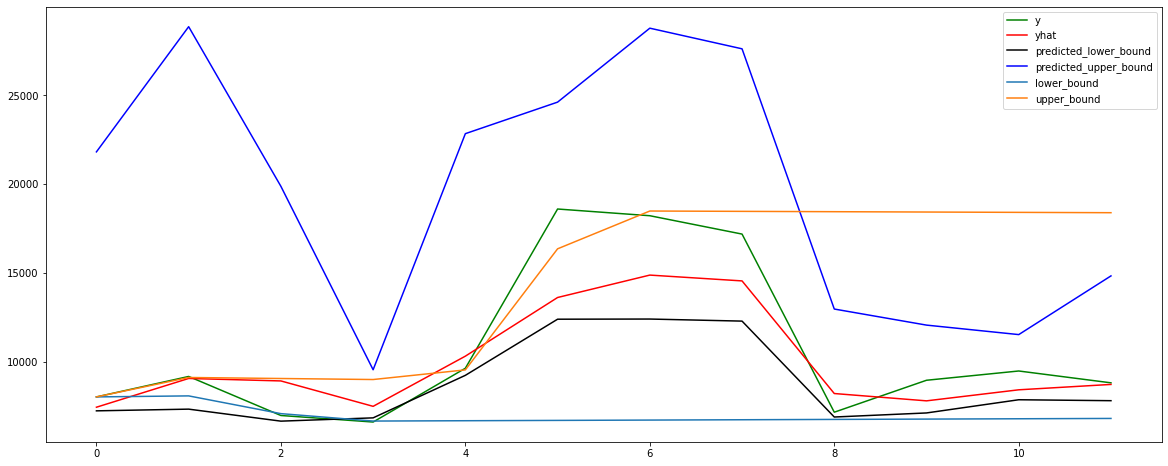

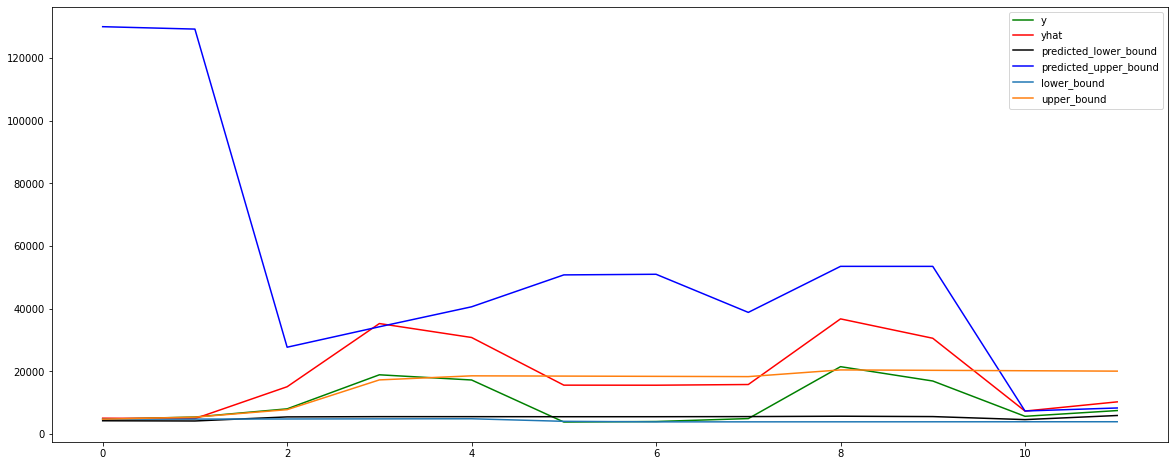

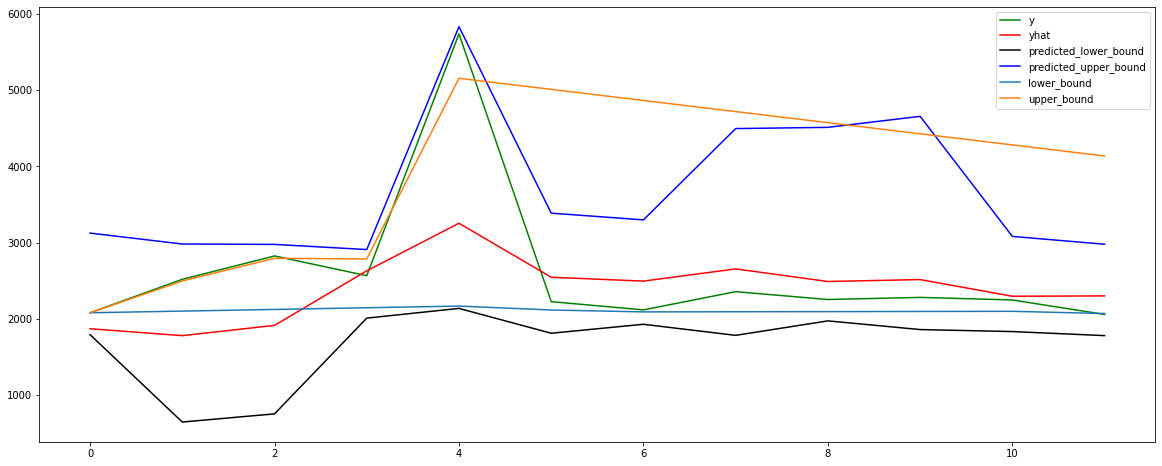

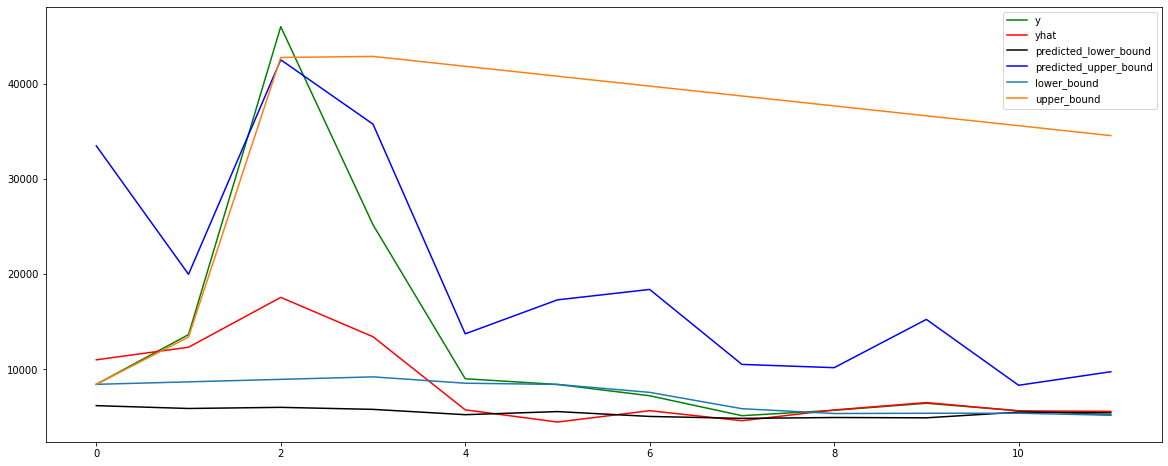

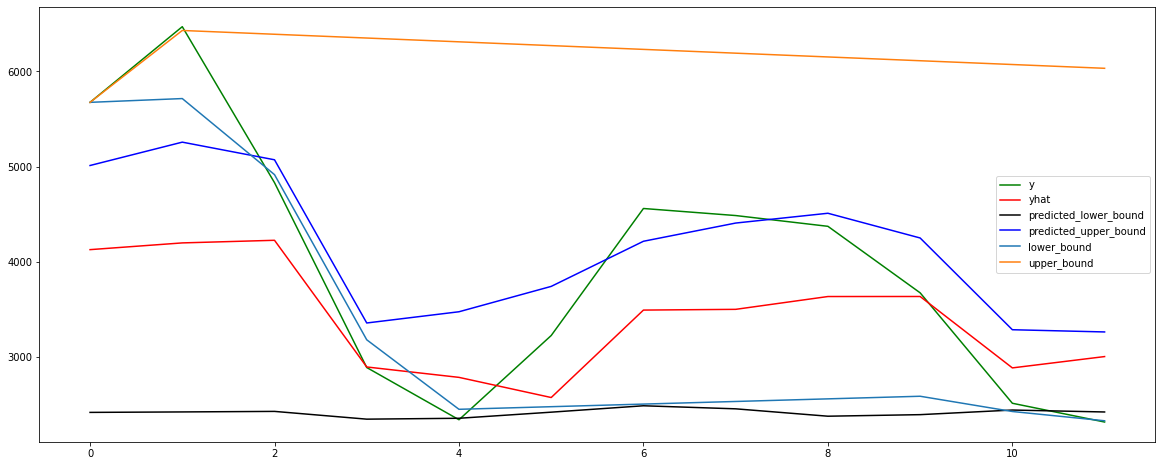

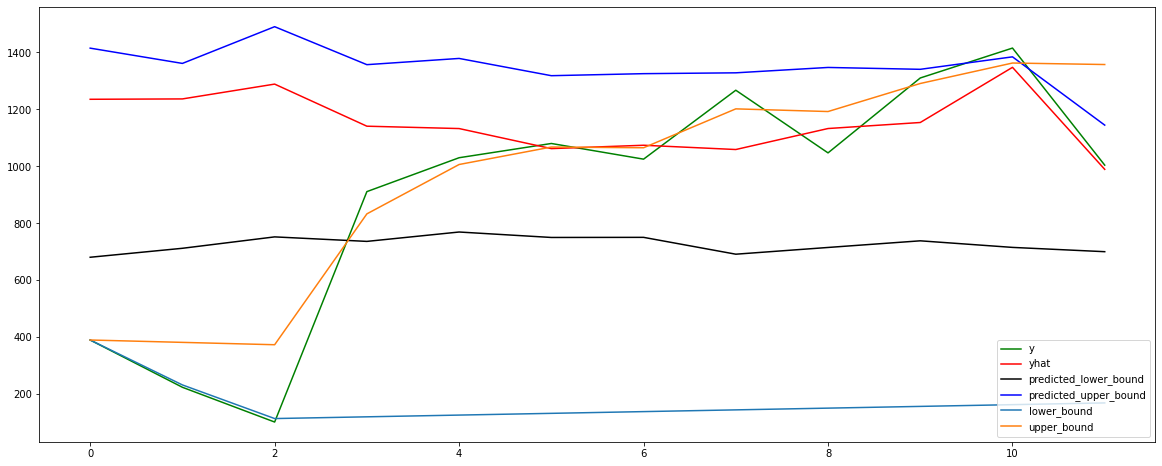

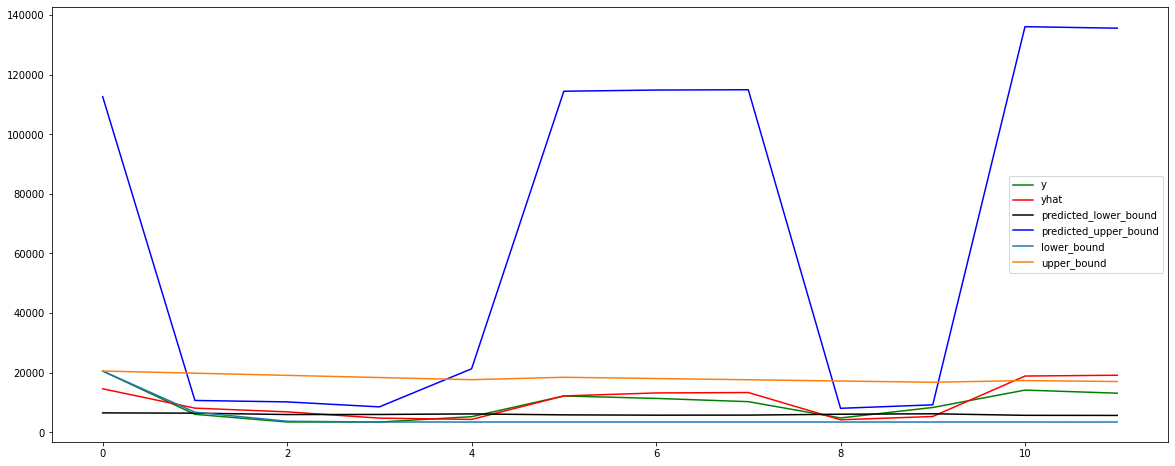

In [ ]:


mapes=[]
ious=[]
brands=[]
periods=[]
m_mean_squared_errors=[]
m_mean_absolute_errors=[]
m_r2s=[] 
m_mape_sks=[]
m_mean_squared_log_errors=[]
for i in ['Brand1', 'Brand2', 'Brand3', 'Brand4', 'Brand5', 'Brand6', 'Brand7']:
  brands.append(i)
  train = df[:199]
  test = df[199:199+12]

  X_train = train.drop([i], axis=1)
  X_test = test.drop([i], axis=1)

  y_train = train[i]
  y_test = test[i]


  alpha = 0.95

  clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                  n_estimators=250, max_depth=3,
                                  learning_rate=.1, min_samples_leaf=9,
                                  min_samples_split=9)

  clf.fit(X_train, y_train)

  # Make the prediction on the meshed x-axis
  y_upper = clf.predict(X_test)

  clf.set_params(alpha=1.0 - alpha)
  clf.fit(X_train, y_train)


  # Make the prediction on the meshed x-axis
  y_lower = clf.predict(X_test)


  #gbr_model = GradientBoostingRegressor(n_estimators=250, max_depth=3,
  #                               learning_rate=.1, min_samples_leaf=9,
                                  #min_samples_split=9)
  #gbr_model.fit(X_train, y_train)



  clf.set_params(alpha=0.5)
  clf.fit(X_train, y_train)
  # Make the prediction on the meshed x-axis
  y_pred = clf.predict(X_test)
  orbit = pd.DataFrame({'y': np.array(y_test), 'yhat': y_pred, 'predicted_lower_bound' : y_lower,  'predicted_upper_bound': y_upper})



  val_list=orbit.y.values
  vals=[]
  perc=[]

  for r in range(len(val_list)):
      l=[x for x in val_list[0:r+1]]
      vals.append(l)

  for value in vals:
      perc.append(np.percentile(value,95)) 
  orbit['upper_bound']=perc

  val_list=orbit.y.values
  vals=[]
  perc=[]
  for r in range(len(val_list)):
      l=[x for x in val_list[0:r+1]]
      vals.append(l)

  for value in vals:
      perc.append(np.percentile(value,5)) 
  orbit['lower_bound']=perc




  orbit['y'].plot(legend=True, figsize=(20,8), color='green')
  orbit['yhat'].plot(legend=True, figsize=(20,8), color='red')
  orbit['predicted_lower_bound'].plot(legend=True, figsize=(20,8), color='black')
  orbit['predicted_upper_bound'].plot(legend=True, figsize=(20,8), color='blue')
  orbit['lower_bound'].plot(legend=True, figsize=(20,8))
  orbit['upper_bound'].plot(legend=True, figsize=(20,8))
  m_iou, m_mape, m_mean_squared_error, m_mean_absolute_error, m_r2, m_mape_sk = return_metrics(orbit)
  mapes.append(m_mape)

  ious.append(m_iou)
  m_mean_squared_errors.append(m_mean_squared_error)
  m_mean_absolute_errors.append(m_mean_absolute_error)
  m_r2s.append(m_r2)
  m_mape_sks.append(m_mape_sk)
  plt.show()




In [ ]:

df_metrics = pd.DataFrame({'brand': brands, 'm_mape': mapes,'m_iou': ious,
                           
                           'm_mean_squared_errors': m_mean_squared_errors, 
                       'm_mean_absolute_errors': m_mean_absolute_errors,
                        'm_r2s': m_r2s,
                        'm_mape_sks': m_mape_sks
                      })


In [ ]:
df_metrics

brand    m_mape     m_iou  ...  m_mean_absolute_errors     m_r2s  m_mape_sks
0  Brand1  0.131015  0.301910  ...             1544.328994  0.767221    0.131015
1  Brand2  1.088012  0.224820  ...             8784.222535 -1.701367    1.088012
2  Brand3  0.164381  0.514059  ...              514.179411  0.279948    0.164381
3  Brand4  0.228259  0.291994  ...             4498.677253  0.382202    0.228259
4  Brand5  0.184822  0.254301  ...              783.738371  0.409140    0.184822
5  Brand6  1.596940  0.250108  ...              331.297670 -0.630765    1.596940
6  Brand7  0.327606  0.187963  ...             2747.612501  0.543245    0.327606

[7 rows x 7 columns]

#Backup

#LSTM mit rollierenden Forecast

In [ ]:
X =[]
y = []

changes = df["Brand1"]
#train = df[:'2017-10-18']
#test = df['2017-10-18':'2017-11-18']
for i in range(0, len(df["Brand1"])-20):
  #print(i)
  
  y.append(changes[i+20:i+21][0])
    
  X.append(np.array(changes[i:i+20]))



In [ ]:
from keras.models import Sequential
from keras.layers import LSTM

In [ ]:


model = Sequential()
model.add(LSTM(1, input_shape=(20, 1)))

model.compile(optimizer="rmsprop", loss="rmse")
model.fit(X, y, batch_size=32, epochs=10)

ValueError: ignored

In [ ]:
model.predict(X)

In [ ]:
#Prophet

In [ ]:
df.reset_index(inplace=True)

In [ ]:
m = Prophet(seasonality_mode='multiplicative' )
df = df.rename(columns={'DATE':'ds', 'Brand1':'y'})
m.fit(df)
future = m.make_future_dataframe(periods=52,freq='W')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


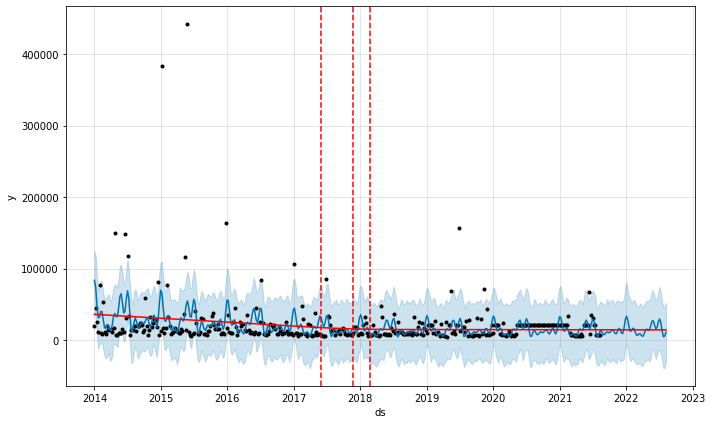

In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

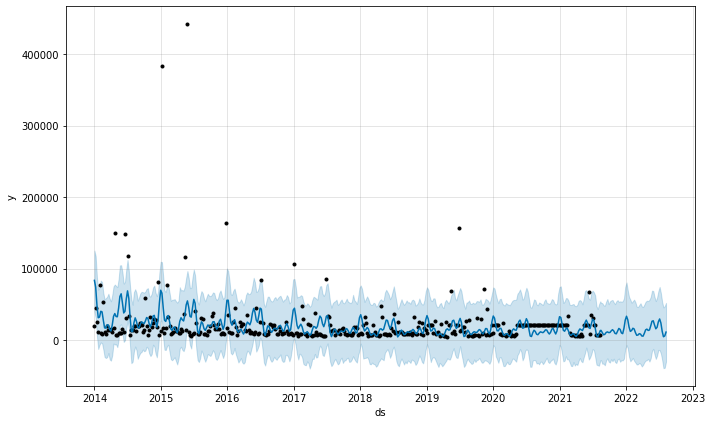

In [ ]:
fig = m.plot(forecast)

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


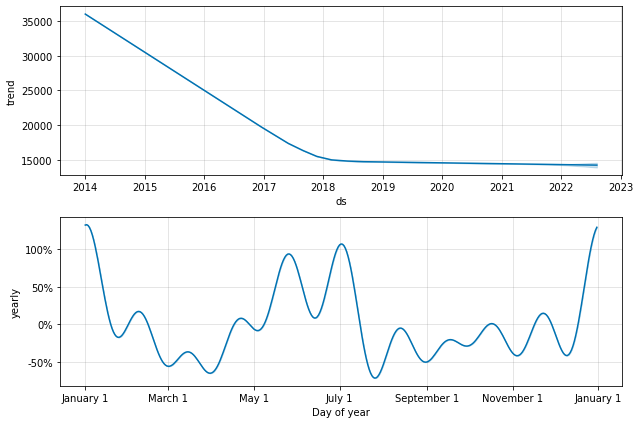

In [ ]:
fig = m.plot_components(forecast)

In [ ]:
#Orbit

In [ ]:
df = df.rename(columns={'DATE':'ds', 'Brand1':'y'})

train = df[:199]
test = df[199:199+48]

dlt = DLT(
  response_col='y', date_col='ds',
  #regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
  seasonality=52,
)
dlt.fit(df=train[['ds', 'y']])

# outcomes data frame
predicted_df = dlt.predict(df=test[['ds', 'y']])

plot_predicted_data(
  training_actual_df=df, predicted_df=predicted_df,
  date_col=dlt.date_col, actual_col=dlt.response_col,
  test_actual_df=df
)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


OSError: ignored

In [ ]:
orbit = pd.merge(test[['ds', 'y']], predicted_df, on='ds', how='left')


In [ ]:
orbit

ds             y  prediction_5    prediction  prediction_95
0  2017-10-25   8016.000000  -7122.831522  18992.590711   47345.084441
1  2017-11-01   9168.000000   -874.969450  21955.150617   41034.262987
2  2017-11-08   6969.000000 -15428.229039  21097.588154   43783.118049
3  2017-11-15   6601.000000     81.571671  22440.857134   54118.773729
4  2017-11-22   9631.000000  -4569.992737  20988.750361   47993.508152
5  2017-11-29  18600.000000  -3915.420397  19623.492639   51797.360568
6  2017-12-06  18222.000000  -1504.404405  20233.717298   40905.700272
7  2017-12-13  17188.000000  -1150.021128  20060.996815   45920.787152
8  2017-12-20   7155.000000  -1541.555153  21905.335985   48616.402533
9  2017-12-27   8954.000000  -3348.518552  17661.012402   43034.217936
10 2018-01-03   9476.000000   -929.852492  25852.960755   50430.470636
11 2018-01-10   8809.000000  -7733.989621  20463.413590   40833.341585
12 2018-01-17  20810.384615  -1972.877220  20383.506524   41313.135286
13 2018-01-24  32910.000000  -1287.568023  21784.820149   53114.291030
14 2018-01-31  23253.000000  -6526.932894  22386.418823   47218.458070
15 2018-02-07   9884.000000  -8752.802134  18957.432535   47899.318589
16 2018-02-14   6330.000000   -880.991151  19010.561022   45848.774758
17 2018-02-21   6413.000000  -8316.885959  18573.254913   44334.595250
18 2018-02-28   6707.000000 -10332.861687  22434.577153   44141.070121
19 2018-03-07   7194.000000 -10616.929109  19056.235673   47650.587399
20 2018-03-14  20810.384615  -3583.254296  19447.582598   47017.928849
21 2018-03-21  11690.000000  -5024.258415  20481.392546   57967.710240
22 2018-03-28   7268.000000  -6941.817566  21414.007326   42745.360214
23 2018-04-04   7094.000000 -13393.229815  21837.494780   46524.799377
24 2018-04-11   5501.000000  -3254.303272  18354.072258   40021.009855
25 2018-04-18   7647.000000  -4671.952576  22338.762707   41652.063323
26 2018-04-25  47397.000000  -2521.946071  21152.783159   47713.904719
27 2018-05-02  31616.000000  -4232.849686  20018.928790   46907.080996
28 2018-05-09   8548.000000  -3345.530727  22611.588073   48925.913760
29 2018-05-16   8445.000000 -14874.179132  18054.050081   42572.309028
30 2018-05-23   8143.000000  -7893.765171  30116.729958   53998.042604
31 2018-05-30   7027.000000  -5589.243796  18639.629954   35868.191057
32 2018-06-06   8143.000000  -7476.328413  20510.538031   47302.228433
33 2018-06-13   7027.000000    575.609727  19090.951708   43637.606926
34 2018-06-20  17095.000000   -276.635574  19313.600069   41545.654196
35 2018-06-27  12208.000000    565.331999  21691.830367   50880.962352
36 2018-07-04  36066.000000  -5902.648883  24476.330832   50395.254092
37 2018-07-11   9471.000000  -9844.610289  18867.702039   51109.835662
38 2018-07-18  10821.000000  -2577.798968  19573.812024   51643.776275
39 2018-07-25  24666.000000  -2591.010686  21175.786879   46122.449369
40 2018-08-01  10658.000000  -9280.680250  21160.126495   46370.205640
41 2018-08-08  11469.000000   1986.815838  20446.938567   41323.722162
42 2018-08-15  10650.000000  -2844.013687  17855.637549   45367.964956
43 2018-08-22   8845.000000  -1168.296615  21696.682704   45768.392400
44 2018-08-29   8878.000000  -3818.246929  19059.165043   39706.473781
45 2018-09-05   8189.000000   -240.899467  19637.382829   49260.557603
46 2018-09-12   8396.000000  -9899.057590  22508.674226   48694.507637
47 2018-09-19   9537.000000 -13307.429546  18842.382761   50175.123501

In [ ]:
orbit['y'].plot(legend=True, figsize=(20,8), color='green')
orbit['prediction'].plot(legend=True, figsize=(20,8), color='red')
orbit['prediction_5'].plot(legend=True, figsize=(20,8), color='black')
orbit['prediction_95'].plot(legend=True, figsize=(20,8), color='blue')

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=orbit['y'],
                   y_pred=orbit['prediction'])

118.03145647397204

In [ ]:
orbit = orbit.rename(columns={'prediction_5': 'predicted_lower_bound', 'prediction_95': 'predicted_upper_bound'})

In [ ]:
val_list=orbit.y.values
vals=[]
perc=[]

for r in range(len(val_list)):
    l=[x for x in val_list[0:r+1]]
    vals.append(l)

for value in vals:
    perc.append(np.percentile(value,95)) #change 50 to the percentile you want to calculate
orbit['upper_bound']=perc



val_list=orbit.y.values
vals=[]
perc=[]
for r in range(len(val_list)):
    l=[x for x in val_list[0:r+1]]
    vals.append(l)

for value in vals:
    perc.append(np.percentile(value,5)) #change 50 to the percentile you want to calculate
orbit['lower_bound']=perc
orbit

ds             y  ...   upper_bound  lower_bound
0  2017-10-25   8016.000000  ...   8016.000000      8016.00
1  2017-11-01   9168.000000  ...   9110.400000      8073.60
2  2017-11-08   6969.000000  ...   9052.800000      7073.70
3  2017-11-15   6601.000000  ...   8995.200000      6656.20
4  2017-11-22   9631.000000  ...   9538.400000      6674.60
5  2017-11-29  18600.000000  ...  16357.750000      6693.00
6  2017-12-06  18222.000000  ...  18486.600000      6711.40
7  2017-12-13  17188.000000  ...  18467.700000      6729.80
8  2017-12-20   7155.000000  ...  18448.800000      6748.20
9  2017-12-27   8954.000000  ...  18429.900000      6766.60
10 2018-01-03   9476.000000  ...  18411.000000      6785.00
11 2018-01-10   8809.000000  ...  18392.100000      6803.40
12 2018-01-17  20810.384615  ...  19484.153846      6821.80
13 2018-01-24  32910.000000  ...  25045.250000      6840.20
14 2018-01-31  23253.000000  ...  26150.100000      6858.60
15 2018-02-07   9884.000000  ...  25667.250000      6877.00
16 2018-02-14   6330.000000  ...  25184.400000      6546.80
17 2018-02-21   6413.000000  ...  24701.550000      6400.55
18 2018-02-28   6707.000000  ...  24218.700000      6404.70
19 2018-03-07   7194.000000  ...  23735.850000      6408.85
20 2018-03-14  20810.384615  ...  23253.000000      6413.00
21 2018-03-21  11690.000000  ...  23130.869231      6422.40
22 2018-03-28   7268.000000  ...  23008.738462      6431.80
23 2018-04-04   7094.000000  ...  22886.607692      6441.20
24 2018-04-11   5501.000000  ...  22764.476923      6346.60
25 2018-04-18   7647.000000  ...  22642.346154      6350.75
26 2018-04-25  47397.000000  ...  30012.900000      6354.90
27 2018-05-02  31616.000000  ...  32457.100000      6359.05
28 2018-05-09   8548.000000  ...  32392.400000      6363.20
29 2018-05-16   8445.000000  ...  32327.700000      6367.35
30 2018-05-23   8143.000000  ...  32263.000000      6371.50
31 2018-05-30   7027.000000  ...  32198.300000      6375.65
32 2018-06-06   8143.000000  ...  32133.600000      6379.80
33 2018-06-13   7027.000000  ...  32068.900000      6383.95
34 2018-06-20  17095.000000  ...  32004.200000      6388.10
35 2018-06-27  12208.000000  ...  31939.500000      6392.25
36 2018-07-04  36066.000000  ...  33541.200000      6396.40
37 2018-07-11   9471.000000  ...  33383.400000      6400.55
38 2018-07-18  10821.000000  ...  33225.600000      6404.70
39 2018-07-25  24666.000000  ...  33067.800000      6408.85
40 2018-08-01  10658.000000  ...  32910.000000      6413.00
41 2018-08-08  11469.000000  ...  32845.300000      6422.40
42 2018-08-15  10650.000000  ...  32780.600000      6431.80
43 2018-08-22   8845.000000  ...  32715.900000      6441.20
44 2018-08-29   8878.000000  ...  32651.200000      6450.60
45 2018-09-05   8189.000000  ...  32586.500000      6460.00
46 2018-09-12   8396.000000  ...  32521.800000      6469.40
47 2018-09-19   9537.000000  ...  32457.100000      6478.80

[48 rows x 7 columns]

In [ ]:
orbit['y'].apply()

12824.91185897436

In [ ]:
def calculate_intersection(lower_bound, upper_bound, predicted_lower_bound, predicted_upper_bound):
    intersection = 0
    if upper_bound < predicted_lower_bound or lower_bound > predicted_upper_bound :
        intersection = 0
    elif lower_bound <= predicted_lower_bound : 
        if upper_bound <= predicted_upper_bound:
            intersection = upper_bound - predicted_lower_bound
        elif upper_bound > predicted_upper_bound:
            intersection = predicted_upper_bound - predicted_lower_bound
    elif lower_bound > predicted_lower_bound:
        if upper_bound >= predicted_upper_bound:
            intersection = predicted_upper_bound - lower_bound
        elif upper_bound < predicted_upper_bound:
            intersection = upper_bound - lower_bound
    return intersection

def calculate_union(lower_bound, upper_bound, predicted_lower_bound, predicted_upper_bound):
    min_ = np.min([lower_bound, upper_bound, predicted_lower_bound, predicted_upper_bound])
    max_ = np.max([lower_bound, upper_bound, predicted_lower_bound, predicted_upper_bound])
    return max_ - min_

In [ ]:
orbit['intersection'] = orbit.apply(lambda x: calculate_intersection(x.lower_bound, x.upper_bound
                                               , x.predicted_lower_bound, x.predicted_upper_bound), axis=1)
orbit['union'] = orbit.apply(lambda x: calculate_union(x.lower_bound, x.upper_bound
                                               , x.predicted_lower_bound, x.predicted_upper_bound), axis=1)

orbit['iou'] = orbit.intersection / orbit.union
orbit['iou'].mean()

0.37074232154465264

In [ ]:
orbit.head(3)

ds       y  ...         union       iou
0 2017-10-25  8016.0  ...  54467.915963  0.000000
1 2017-11-01  9168.0  ...  41909.232437  0.024739
2 2017-11-08  6969.0  ...  59211.347087  0.033424

[3 rows x 10 columns]

<AxesSubplot:>

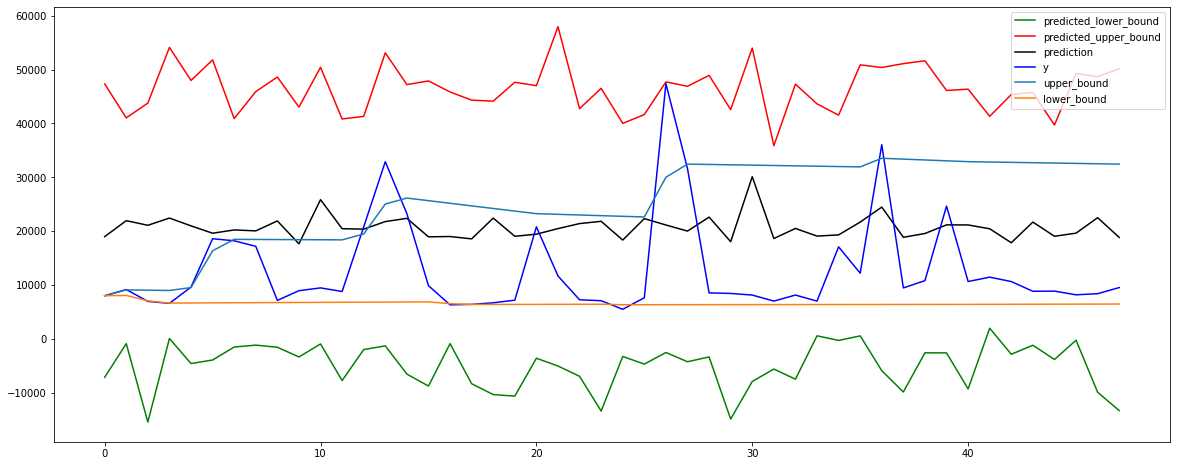

In [ ]:
orbit['predicted_lower_bound'].plot(legend=True, figsize=(20,8), color='green')
orbit['predicted_upper_bound'].plot(legend=True, figsize=(20,8), color='red')
orbit['prediction'].plot(legend=True, figsize=(20,8), color='black')
orbit['y'].plot(legend=True, figsize=(20,8), color='blue')
orbit['upper_bound'].plot(legend=True, figsize=(20,8))
orbit['lower_bound'].plot(legend=True, figsize=(20,8))

In [ ]:
#Feature engineering

In [ ]:
#Predictions mit xgboost

In [ ]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['Brand1'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['Brand1'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

ValueError: ignored